# Project 2 - Forecast correction

## Assignment Overview

The aim of the assignment is to correct ensemble forecasts to be able to predict with more accuracy temperatures in a small region in Brussel.

We will use machine learing techniques to correct the forecasts for 2024 given past ensemble forecasts and the corresponding measured temperature value at the vlinder station.

https://www.ecmwf.int/en/newsletter/166/meteorology/statistical-post-processing-ensemble-forecasts-belgian-met-service

### Data Preprocessing

We need high quality data before we can train our models. We will first analyse our target data (measured temperatures at vlinder station). We will see that some measurement are erroneous and thus remove them. We will then analyse features from the ensemble forecast and relate them to our target data to make informed choices on which features to keep for our training.

In order to visualize dependencies within our data more easily all the different ensemble forecasts are not directly merged into one dataframe, they are kept in a list of tuples (date, fc) where date is a string representing the start date of the forecast and fc is a dataframe holding the ensemble forcast.

### Used Algorithms

- Linear regression
- Random forest regression
- Multi layer perceptron

In [1]:
%pip install codecarbon
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from codecarbon import track_emissions, EmissionsTracker
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import math
import glob
import datetime
from functools import partial, reduce, wraps
from collections import defaultdict  
from itertools import chain, accumulate
import random
import operator
from abc import ABC, abstractmethod
from scipy.stats import linregress
import time as time_tool
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,train_test_split
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV, mutual_info_regression, SelectKBest
from abc import ABC, abstractmethod
random.seed(42)
# 0 degre Celius in Kelvin
C_0 = 273.15
plt.style.use('seaborn-v0_8-colorblind')

#from https://stackoverflow.com/questions/16739290/composing-functions-in-python
def compose (*functions):
    """
        Enables function composition
    """
    def inner(arg):
        for f in reversed(functions):
            arg = f(arg)
        return arg
    return inner

def identity(x):
    return x

# from https://realpython.com/primer-on-python-decorators/
def timer(func):

    """Print the runtime of the decorated function"""

    wraps(func)

    def wrapper_timer(*args, **kwargs):
        rows = None
        if isinstance(args[1], pd.DataFrame):
            rows = args[1].shape[0]
        start_time = time_tool.perf_counter()

        value = func(*args, **kwargs)

        end_time = time_tool.perf_counter()

        run_time = end_time - start_time

        print(f"Finished {func.__name__}() in {run_time:.4f} secs for {rows} elements")

        return value

    return wrapper_timer

# Match data sets

We will first build a class to handle ensemble forecasts.

Then we will build a class to handle Vlinder data.

Ensemble forecasts and vlinder data are both in their own classes. We can then build methods to query specific type of data and rebuild dataframes. This makes it easier to visualize data and try out multiple things.


## Forecast data sets

Class handeling ensemble forecasts. This is done to be able to create and access forecasts in a determined way as well as computing helpfull information.


- `get_ensemble_forecast(date)` gives the ensemble forecast starting at `date`.
- `get_df()` returns one dataframe with all ensemble forecasts where forecasts are indexed by their starting date

In [3]:
# Create of Main DataFrame
class EnsembleForecast:
    def __init__(self):
        self.df = self._create_df()

    def _extract_datetime(self, file_name):
        """
            Extracts datetime object from file_name 
            Returns datetime if successful, None otherwise
        """
        try:
            strings_of_date = file_name.replace('.', '_').split('_')[1:4]
            d, m, y = tuple(map(int, strings_of_date))
            return datetime.datetime(y, m, d)
        except Exception as e:
            print(f"Forecast csv does not respect date_month_year.csv format: {e}\n {file_name} dropped")
        return None

    def _create_df(self):
        """
            Creates dataframe where each ensemble forecast is accessible by its start date
        """
        df_f = pd.DataFrame()
        for file_name in glob.glob("forecast/"+'*.csv'): 
            start_time = self._extract_datetime(file_name)
            if start_time != None:
                to_add = pd.read_csv(file_name)
                to_add['Start'] = start_time
                df_f = pd.concat([df_f, to_add])
            else:
                pass
        self.time_str = df_f.columns.to_list()[0]
        df_f = df_f.sort_values(by='Start', kind='mergesort')
        return df_f.set_index(['Start', 'time']).sort_index()

    def get_df(self):
        return self.df

    def get_min_max(self):
        """
            Returns earliest and latest date available in the ensemble forecasts
        """
        select_time = self.df.index.get_level_values('time')
        return (select_time.min(), select_time.max())
        
    def get_start_dates(self):
        """
            Returns a list start date of ensemble forecast
        """
        lst = list(set(self.df.index.get_level_values('Start')))
        lst.sort()
        return lst

    def get_ensemble_forecast(self, date):
        """
            Returns ensemble forecast given date
            date format (%Y-%M-%D %h:%m:%s)
        """
        return self.df.loc[date]

forecast_data = EnsembleForecast()

forecast_min, forecast_max = forecast_data.get_min_max()

df_all = forecast_data.get_df()
print(forecast_data.get_min_max())

('2023-02-01 00:00:00', '2023-07-07 00:00:00')


## Vlinder Data

Vlinder data set is inside a Vlinder class. This makes it easier to query and display subsets of data

We need to check for inconsitent data points in the the vlinder set and then resample it to match the ensemble forecast

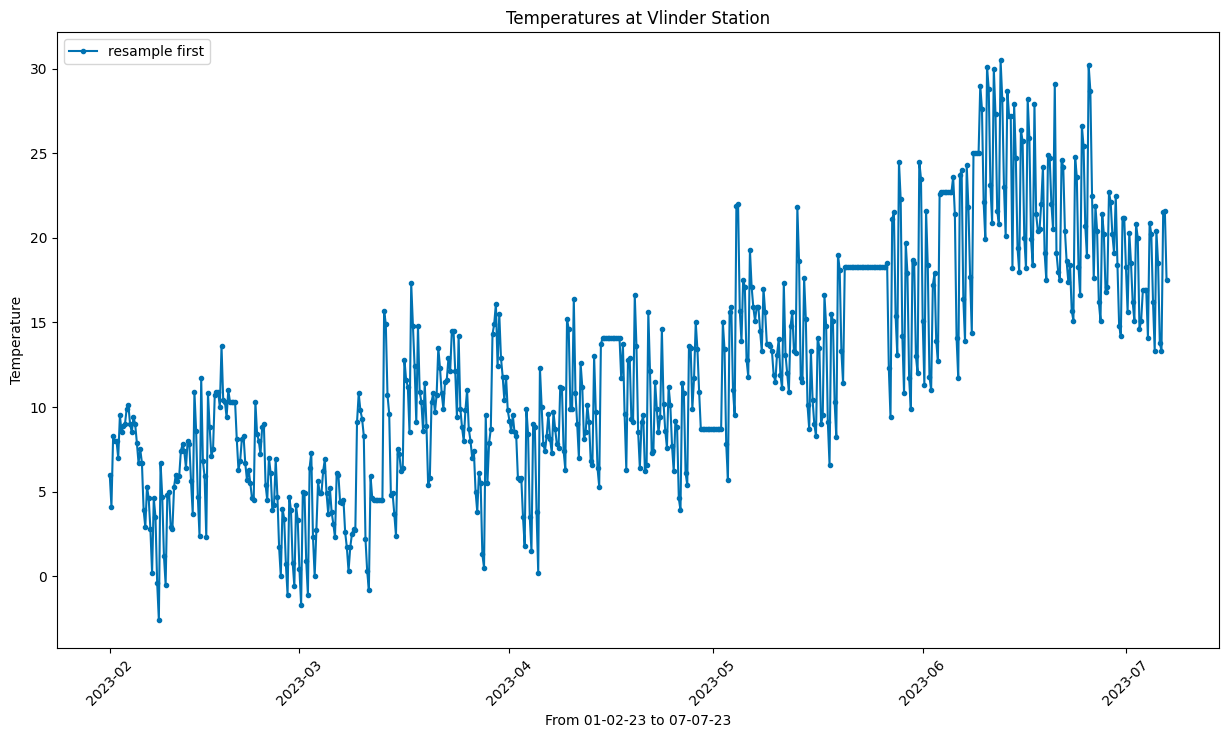

In [4]:
class Vlinder: 
    """
        Class that represents Vlinder data
        Holds original data in self.df 
        Holds resampled data in self.resample
    """
    
    def __init__(self, path_to_csv):
        self.df = pd.read_csv(path_to_csv)
        self.temp_str = self.df.columns.tolist()[0]
        self.time_str = self.df.columns.tolist()[1]
        self.df[self.time_str] = pd.to_datetime(self.df[self.time_str])
        self.resample = {"first" :  self.df.set_index(self.time_str).resample('6h').first().reset_index(),
                        "mean" : self.df.set_index(self.time_str).resample('6h').mean().reset_index()}

    def apply_dates_resize(self, first, snd):
        """
            Does a partial application of dates as we often want the same dates for different dataframes
        """
        return partial(self.resize_on_time, start=first, finish=snd)

    #TODO refactore horrible code
    def _get_time(self, df, start, finish):
        """
            Helper function to set start and finish to the min
            Start and finish can be either None, string or datetime
            Returns datetime object
        """
        if start is None: 
            start = self.earliest(df)
        elif isinstance(start, str):
            start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        else: 
            pass
        if finish is None: 
            finish = self.latest(df) 
        elif isinstance(finish, str):
            finish = datetime.datetime.strptime(finish, "%Y-%m-%d %H:%M:%S")
        else:
            pass
        return (start, finish)
        
    
    def dataframe_of_string(func):
        """
            Decorator function used to convert input dataframe string into actual dataframe
            If passed in argument is already a dataframe does nothing and passes data framethrough
            Carefull: input type is a string, new type is a dataframe
        """
        def wrapper(self, type="df", *args, **kwargs):
            if isinstance(type, str):
                type = self.select_type(type)
            return func(self, type, *args, **kwargs)
        return wrapper

    #Does not work well when chaining decorators together => Unused atm
    def handle_time(func):
        """
            Decorator used to handle start and finish times
        """
        def wrapper(self, *args, **kwargs):
            if start is None:
                start = self.earliest()
            if finish is None:
                finish = self.latest()
            return func(self, df, start, finish, *args, **kwargs)
        return wrapper

    
    def select_type(self, type="df"):
        """
            Returns dataframe corresponding to type
            types available: 
            - df : original dataframe
            - mean : dataframe resampled on mean
            - first : dataframe resampled on first
        """
        df = None
        match type:
            case "df":
                df = self.df
            case "mean":
                df = self.resample["mean"]
            case "first":
                df = self.resample["first"]
            case _ :
                raise ValueError(f"dataframe {type} does not exist")
        return df
    
    @dataframe_of_string
    def earliest(self, type="df"):
        """
            Returns earliest date in dataframe
        """
        return min(type[self.time_str])

    @dataframe_of_string
    def latest(self, type="df"):
        """
            Returns latest date in dataframe
        """
        return max(type[self.time_str])

    def plot(self, start=None, finish=None):
        """
            Plots original data points as well as resampeled on mean and first
        """
        start , finish = self._get_time(self.df, start, finish)

        # partial application of dates
        select_df = self.apply_dates_resize(start, finish)

        mean = select_df("mean")
        first = select_df("first")
        base = select_df("df")
        
        plt.figure(figsize=(15, 8))
        plt.plot(first[self.time_str], first[self.temp_str], label='resampled first', marker='o', markersize=2, linewidth=1)
        plt.plot(mean[self.time_str], mean[self.temp_str], label='resampled mean',  marker='s', markersize=2, linewidth=1)
        #plt.plot(base[self.time_str], base[self.temp_str], label='original', linestyle='--', linewidth=0.7)
        plt.legend(loc='upper left')
        plt.xlabel(f"""From {start.strftime("%d-%m-%y")} to {finish.strftime("%d-%m-%y")}""")
        plt.ylabel('Temperature')
        plt.title(f'Temperatures at Vlinder Station')
        plt.xticks(rotation=45)
        plt.show()
    
    @dataframe_of_string
    def plot_one(self, type="df", start=None, finish=None, info="df"):
        """
            Plots one of the dataframes, either df, mean or first
        """
        start , finish = self._get_time(type, start, finish)
        df_resize = self.resize_on_time(type, start, finish)
        plt.figure(figsize=(15, 8))
        plt.plot(df_resize[self.time_str], df_resize[self.temp_str], marker='o',  markersize=3, label=info) #cannot use type as label as it has been changed to dataframe through decorator
        plt.legend(loc='upper left')
        plt.xlabel(f"""From {start.strftime("%d-%m-%y")} to {finish.strftime("%d-%m-%y")}""")
        plt.ylabel('Temperature')
        plt.title(f'Temperatures at Vlinder Station')
        plt.xticks(rotation=45)
        plt.savefig(f'../{info}.png',  bbox_inches='tight')
        plt.show()

    @dataframe_of_string
    def resize_on_time(self, type="df", start=None, finish=None):
        """
            Returns new data frame with values between start and finish
            type specifies on which dataframe to apply resizing (df for original, mean for resample mean and first for resample first)
            Format (%Y-%M-%D %h:%m:%s)
            
            On why start and finish = None: https://stackoverflow.com/questions/1802971/nameerror-name-self-is-not-defined
        """
        start , finish = self._get_time(type, start, finish)
        assert start >= self.earliest(type), f"{start} does not exist in dataframe"
        assert finish <= self.latest(type), f"{finish} dies not exist in dataframe"
        return type[(type[self.time_str] >= start) & (type[self.time_str] <= finish)]  

    @dataframe_of_string
    def drop_between(self, type="df", start=None, finish=None):
        """
        Drops values between [start, finish].
        If string is passed, returns new dataframe with dropped values.
        If dataframe is passed, exculdes values from that dataframe
        """
        start , finish = self._get_time(type, start, finish)
        before = type[type[self.time_str] < start]
        after = type[type[self.time_str] > finish]
        return pd.concat([before, after])

    @dataframe_of_string
    def get_cst_intervals(self, type="df"):
        """
            Returns start, end and timedelta of all constant intervals in passed dataframe
        """
        #from https://stackoverflow.com/questions/66684957/is-there-a-faster-way-for-finding-the-range-of-constant-values-in-a-dataframe
        #Compares current element with prev, if (not equal) => True (1), else False (0). cumulative sum then adds.
        #If different sum goes up, else stays constant
        df = type
        groupr = df.temp.ne(df.temp.shift()).cumsum()
        #creates group of (nb, timestamp)
        mapper = list(zip(groupr, df.datetime))
        #from https://stackoverflow.com/questions/71945206/keep-duplciate-items-in-list-of-tuples-if-only-the-first-index-matches-between-t
        dct = defaultdict(list)
        for tup in mapper:
            first, _ = tup
            dct[first].append(tup)
            onlydups = [lst for firstelem, lst in dct.items() if len(lst) > 1]
        #only dups is a list of list with duplicate items
        min_max_lst = []
        for dup in onlydups:
            start = dup[0][1]
            end = dup[-1][1]
            min_max_lst.append((start, end, end - start))
        return min_max_lst

    @dataframe_of_string
    def drop_cst(self, type="df", max_delta=6):
        """
            Keeps all constant time intervals that are stricly bigger than max_delta
            Computes const values through get_cst_intervals
        """
        df = type
        min_max_lst = self.get_cst_intervals(df)
        for timestamps in min_max_lst:
            fst = str(timestamps[0])
            snd = str(timestamps[1])
            delta = (pd.to_datetime(snd) - pd.to_datetime(fst)) / np.timedelta64(1, 'h')
            if (delta > max_delta):
                df = vlinder_data.drop_between(df, start=fst, finish=snd)
        return df

vlinder_data = Vlinder('vlinder19_2023.csv')

#Plot vlinder data on time frame of forecast date avaiable
vlinder_data.plot_one(type="first", start=forecast_min, finish=forecast_max, info="resample first")

We can see from our resampled data that there are multiple periods where temperature seems to be constant. This probably indicates a measument error. We will exclude all those inadequat values from our data.

We compute all constant time intervals through the function `get_cst_intervals()`. We can then drop them by calling `drop_cst(df, max_delta)`, where `max_delta` represents consecutive constant time intervals to keep (-> if max_delta = 6, we keep all intervals that are constant on 6hours intervals or less).

We do this because it might be possible that by chance, measured temperatures on consecutive time intervals are the same. However a too long constant interval probably indicates a measurement error.

It is usefull to see what are the most common intervals where const values appear.

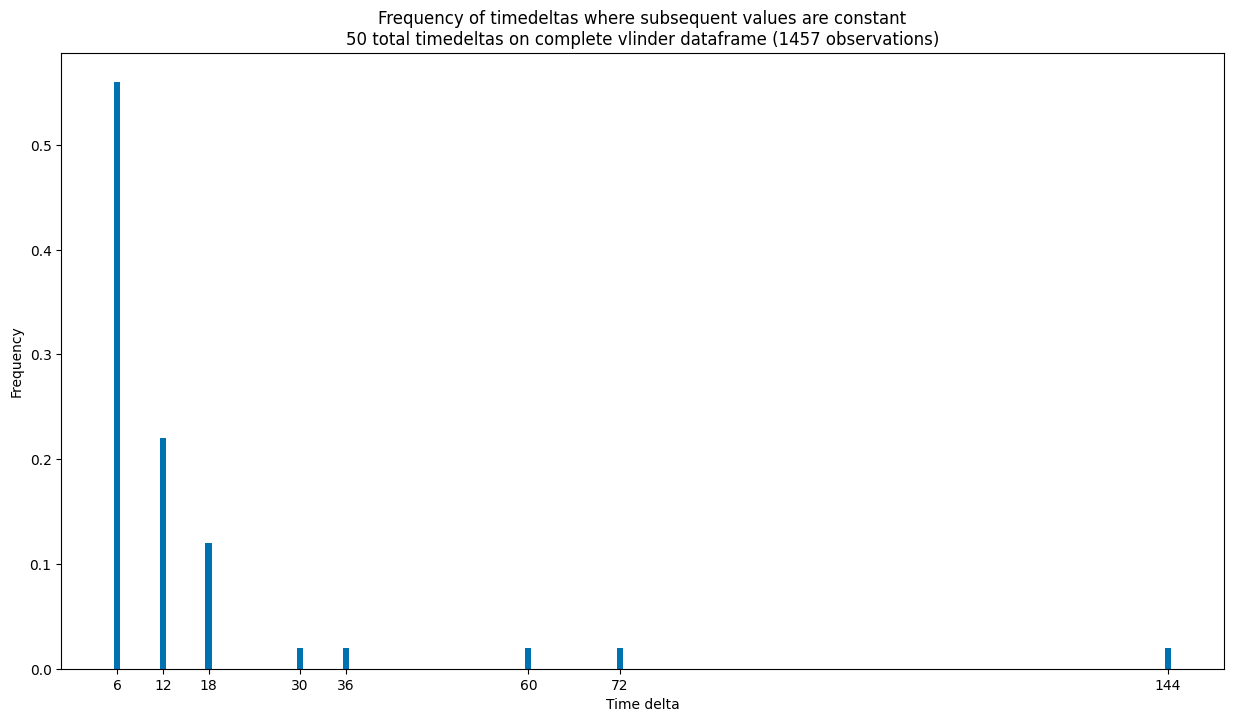

In [5]:
cst_intervals_first = vlinder_data.get_cst_intervals("first")
total_obs = len(vlinder_data.select_type("first"))
# makes list of time deltas
time_delta = list(map(lambda x : x[2], cst_intervals_first))
time_delta_to_hours = (list(map(lambda x : x.total_seconds() / 3600, time_delta)))
total_cst_elements = len(time_delta)
time, occ = np.unique(time_delta_to_hours, return_counts=True)
occ = list(map(lambda x : x / len(time_delta), occ))
plt.figure(figsize=(15, 8))
plt.bar(time, occ)
plt.xlabel('Time delta')
plt.ylabel('Frequency')
plt.xticks(time)
plt.title(f'Frequency of timedeltas where subsequent values are constant\n{total_cst_elements} total timedeltas on complete vlinder dataframe ({total_obs} observations)')
plt.savefig('../freq_vlinder.png', bbox_inches='tight')
plt.show()

In [6]:
print(occ[0] + occ[1]) 

0.78


Intervals of 6 and 12 hours where consecutive values are constant represent 78% of our total time deltas. It might be probable that by random chance two intervals within 12 hours are similar. (6 hours means 2 consecutive values, 12 hours means 3 consecutive values).

When running different models, best results where achieved when max_delta = 0 (no constant intervals are kept). Correlation between `t2m` (temperature at 2 meters from ensemble forecast) and `temp` (measured temperature at station) is also highest when max_delta = 0. Those are not are really accurate method of drawing conclusions, we should do Hypothesis testing to see what conculusions we can draw.

`drop_cst(max_delta)` is a function that drops all time intervals bigger than its given argument

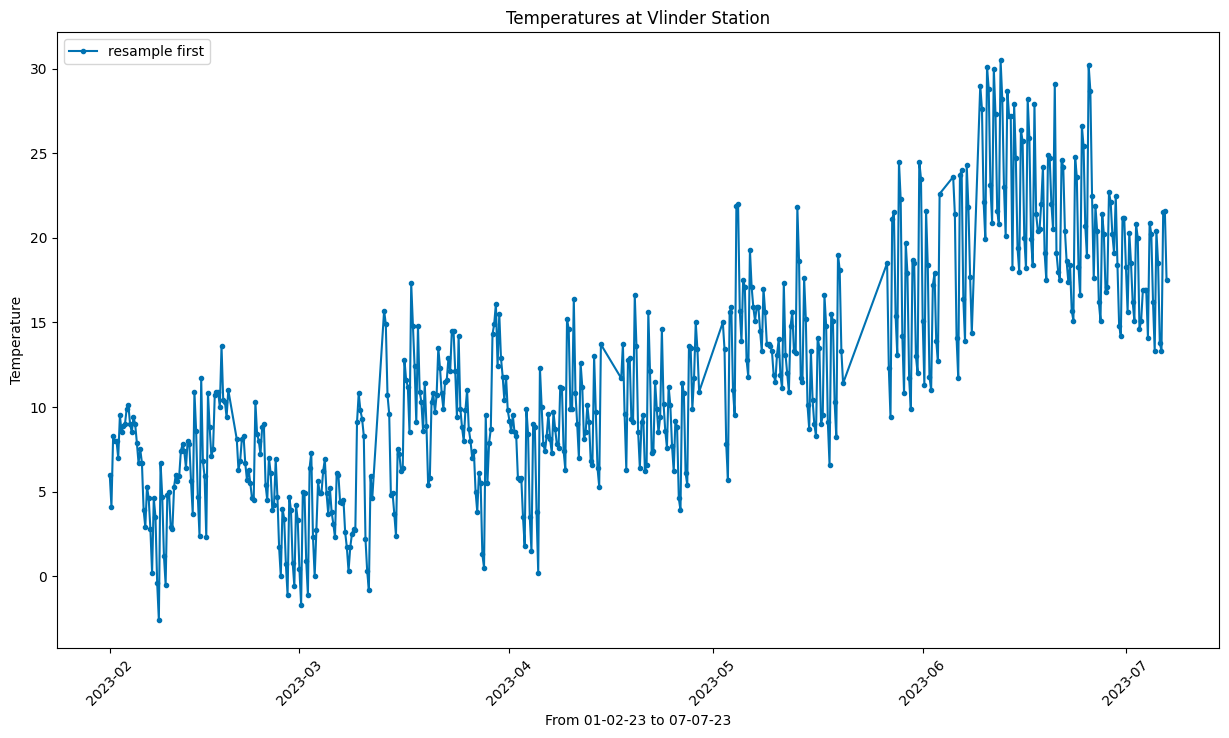

In [7]:
df = vlinder_data.resize_on_time("first", start=forecast_min, finish=forecast_max)
df = vlinder_data.drop_cst(df, 12)
vlinder_data.plot_one(df, info="resample first")

Partial function application to select what vlinder data we should keep.

In [8]:
drop_const_p = partial(vlinder_data.drop_cst, max_delta=0)

## Integrating Forecast and Vlinder Temperaturs
1. We need to know how to resample our Vlinder Data.
   - Compute the mean of 't2m' (which will be our explanatory variable) and correlated it to the ressampled vlinder data. We then choose the highest correlated resampling method
2. We can then merge ensemble forecasts with observed vlinder data

### 1. Selection of resampling technique

We need to decide whether the mean or the first value is the right choice when resampling our Vlinder Data.
We compute correlation between the mean temperature (t2m) in the forecasts and the temperature at the vlinder station.

In [9]:
target = 't2m'

ensmean_forecast = forecast_data.get_df().groupby('time')[target].mean().reset_index()
ensmean_forecast[target] = ensmean_forecast[target] - C_0
ensmean_forecast['time'] = pd.to_datetime(ensmean_forecast['time'])
ensmean_min, ensmean_max = forecast_data.get_min_max()

resize_vlinder = vlinder_data.apply_dates_resize(forecast_min, forecast_max)

dropped_vlinder_mean = drop_const_p(resize_vlinder("mean"))
dropped_vlinder_first = drop_const_p(resize_vlinder("first"))

merge_p = partial(pd.merge, left_on=forecast_data.time_str, right_on=vlinder_data.time_str)
merged_df = merge_p(ensmean_forecast, dropped_vlinder_mean).drop(columns=[vlinder_data.time_str]).rename(columns={vlinder_data.temp_str: 'mean'})
merged_df = merge_p(merged_df, dropped_vlinder_first).drop(columns=[vlinder_data.time_str]).rename(columns={vlinder_data.temp_str: 'first'})

correlation_mean = merged_df['t2m'].corr(merged_df['mean'])
correlation_first = merged_df['t2m'].corr(merged_df['first'])

print(correlation_mean, correlation_first)

0.9480840831965944 0.976521388963622


We can see that resampling on first value found in the interval has a higher correlation with our main target value 't2m'. We will use this resampling technique from now on.

### 2 Merging ensemble forecasts and vlinder temperatures

We will keep all ensemble forecasts inside a list and not merge them directly inside a unique dataframe. This helps with visualization of data as well as making it easier to target individual ensemble forecasts. It also makes it more flexible to select certain dataframes in case we dont want them for some reason. This will come up handy later. We can easily do operations on those dataframes using list processing techniques such as map, reduce and partial application.

In [10]:
def create_ens_fc_list():
    """
        Creates a list of tuples containing (start_date : string, ensemble forecast: dataframe). 
        All ensemble forecast dataframes are augmented with the respective vlinder data.
        This means that some dataframes may contain less predictions as the corresponding vlinder measurement was unusable
    """
    # get list of starting dates of ensemble forecasts
    starting_dates = forecast_data.get_start_dates()
    
    # get corresponding vlinder data with constant values dropped as decided by drop_const_p
    vlinder_temp =  drop_const_p(resize_vlinder("first"))

    dfs = []
    for date in starting_dates:
        df = forecast_data.get_ensemble_forecast(date).reset_index()
        df[forecast_data.time_str] = pd.to_datetime(df[forecast_data.time_str])
        df = pd.merge(df, vlinder_temp, left_on=forecast_data.time_str, right_on=vlinder_data.time_str)
        df.drop(columns=vlinder_data.time_str, inplace=True)
        # We need to redefine date here as the inital date could be dropped because it does not exist in the vlinder set
        # This might create data frames with the same starting date.
        date = df['time'][0]
        # if a duplicate date exists we keep the dataframe which has the most elements
        current_dates = list(map(lambda tp: tp[0], dfs))
        if date in current_dates:
            index = current_dates.index(date)
            # if the current dataframe contains more info than the current one in the list
            if (len(df) > len(dfs[index][1])): 
                # we remove element at that index
                dfs.pop(index)
        
        dfs.append((date, df))
    
    return dfs


#Some utility functions use to handle list of tuples generated by previous function
def nb_observation(df):
    return len(df.index) // 50

def date_and_obs(tp):
    start, df = tp
    return (str(start), nb_observation(df))

def only_date(tp):
    date, _ = tp 
    return date

def only_df(tp):
    _, df = tp
    return df

def merge_df(df_1, df_2):
    """
        Merges two dataframes
    """
    combined_df = pd.concat([df_1, df_2], ignore_index=False)
    return combined_df

def reduce_df(dfs_list):
    """
        Reduces all dataframes from the input list into one
    """
    reduced_df = reduce(merge_df, map(only_df, dfs_list))
    return reduced_df

dfs = create_ens_fc_list();
#contains number of observation left for each time forecast
samples_per_fc = list(map(date_and_obs, dfs))
df = pd.DataFrame(samples_per_fc, columns=['Start', 'Number of Entries'])
#df.set_index('Start', inplace=True)
df.to_csv('Entries.csv')
df

Start  Number of Entries
0   2023-02-01 00:00:00                 27
1   2023-02-03 00:00:00                 29
2   2023-02-05 00:00:00                 29
3   2023-02-07 00:00:00                 29
4   2023-02-10 00:00:00                 27
5   2023-02-13 00:00:00                 23
6   2023-02-15 00:00:00                 23
7   2023-02-17 06:00:00                 24
8   2023-02-20 00:00:00                 29
9   2023-02-22 00:00:00                 29
10  2023-02-25 00:00:00                 28
11  2023-02-27 00:00:00                 27
12  2023-03-01 00:00:00                 27
13  2023-03-02 00:00:00                 27
14  2023-03-03 00:00:00                 27
15  2023-03-07 00:00:00                 23
16  2023-03-10 00:00:00                 23
17  2023-03-13 12:00:00                 27
18  2023-03-15 00:00:00                 29
19  2023-03-17 00:00:00                 27
20  2023-03-19 00:00:00                 27
21  2023-03-22 00:00:00                 27
22  2023-03-25 00:00:00                 29
23  2023-03-28 00:00:00                 29
24  2023-03-30 00:00:00                 29
25  2023-04-03 00:00:00                 28
26  2023-04-05 00:00:00                 27
27  2023-04-08 00:00:00                 25
28  2023-04-10 12:00:00                 17
29  2023-04-13 00:00:00                 18
30  2023-04-17 12:00:00                 19
31  2023-04-18 00:00:00                 29
32  2023-04-20 00:00:00                 29
33  2023-04-23 00:00:00                 25
34  2023-04-25 00:00:00                 17
35  2023-04-28 00:00:00                 16
36  2023-05-02 12:00:00                 19
37  2023-05-03 00:00:00                 25
38  2023-05-05 00:00:00                 25
39  2023-05-08 00:00:00                 27
40  2023-05-10 00:00:00                 29
41  2023-05-13 00:00:00                 29
42  2023-05-15 00:00:00                 22
43  2023-05-18 00:00:00                 10
44  2023-05-20 00:00:00                  4
45  2023-05-26 18:00:00                 22
46  2023-05-28 00:00:00                 27
47  2023-05-30 00:00:00                 22
48  2023-06-03 00:00:00                 18
49  2023-06-05 12:00:00                 23
50  2023-06-08 00:00:00                 23
51  2023-06-10 00:00:00                 27
52  2023-06-13 00:00:00                 27
53  2023-06-15 00:00:00                 29
54  2023-06-18 00:00:00                 29
55  2023-06-20 00:00:00                 29
56  2023-06-23 00:00:00                 29
57  2023-06-25 00:00:00                 27
58  2023-06-28 00:00:00                 24
59  2023-06-30 00:00:00                 24

Except for the forecast starting on `2023-05-20 00:00:00`, most of the forecast still have information left in them. We will remove this forecast as it does not give enough information to accurately depcit an ensemble forecast

In [11]:
#timestamp object of forecast that the least amount of info (here 4)
not_enough_info = pd.to_datetime(min(samples_per_fc, key=lambda x: x[1])[0])
not_enough_info

Timestamp('2023-05-20 00:00:00')

In [12]:
number_of_obs = reduce(lambda x, y: x + y, map(lambda tp : tp[1], samples_per_fc))
number_of_obs

1495

# Urban Heat Island effect

The urban heat island (UHI) effect explains why urban areas are warmer than rural areas. 
- Vertical buildings collect more solar radiation.
- Black construction materials have a lower albedo.
- Solar radiation is not reflected directly back up to the atmospher due to the 3D nature of streets.
- Temperatures are not lowered by Evapotranspiration or evaporation or shaded areas.
- Nearby human activity concentration (Combustion gases, air-conditioning...) also increases temperatures
[Source](https://environnement.brussels/citoyen/outils-et-donnees/etat-des-lieux-de-lenvironnement/climat-etat-des-lieux#cartographie-des-ilots-de-fraicheur-bruxelles)

UHI is:
- stronger at night
- stronger when winds are weak
- stronger under block conditions
- affected by the surroundings, being weaker around vegetation.
- affected by cloud cover


[src2](https://en.wikipedia.org/wiki/Urban_heat_island), [src1](https://earthscience.stackexchange.com/questions/2186/is-the-urban-heat-island-effect-stronger-during-a-particular-season-or-part-of-t)

We can see this Urban Heat Island effect appear when plotting the bias between our ensemble forecast and the measured temperature at the vlinder station.

We will try here to take the heat island effect into consideration, creating new features that might produce a better represention of the underlying problem.

# Analysis of relation between target temperature and ensemble forecasts

We will first analyse the difference between the measured temperature at the vlinder station and the t2m variable (= bias of our ensemble forecast) to see if there are any difference thourghout the year. Does the forecast overshoot or undershoot the measured data depending on season of the year? 
This will help understanding the UHI and also select the right way of splitting our data (if no patterns appear throughout the year, we can split chronologically)

This analysis will also help to remove outliers in our data. We will find relative errors with abnormal variance/mean.

In [13]:
df_diff = create_ens_fc_list()

def keep_columns(to_keep, df):    
    return df[to_keep]

def group_time(df):
    mean_fc = df.groupby('time').mean()
    mean_fc['t2m'] = mean_fc['t2m'] - C_0
    return mean_fc

def diff_tm2_tmp(df):
    df['diff'] =  df['t2m'] - df['temp']
    return df

def create_mean(df):
    """
        Creates column holding mean of difference 
        Requires that diff column has already been computed
    """
    df['mean_diff'] = df['diff'].mean()
    return df

keep_cols = partial(keep_columns, ['time', 't2m', 'temp'])

operations = compose(create_mean, diff_tm2_tmp, group_time, keep_cols, only_df)

list_df_diff = list(map(operations, df_diff))

For each forecast we will compute the mean and the variance of the relative error. This will show extreme values we can then remove. We will also verify if there are trends on a seasonal basis, this will help to split the data into different splits later.

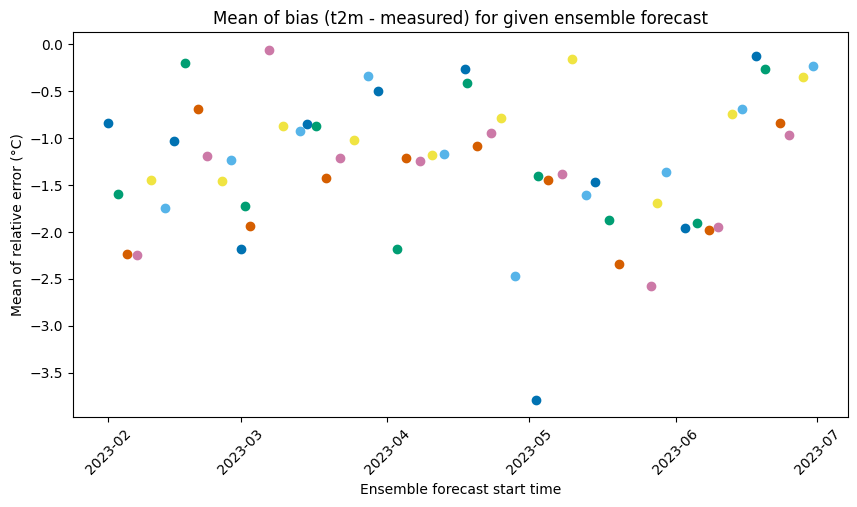

In [14]:
def compute_variance(target, df):
    """
        Computes variance on columns for given dataframe
    """
    df[f'{target} var'] = df[target].var()
    return df

def scatter_list_var(df_lst, on='diff var', ylabel='missing label', title="missing title"):
    """
        Plots all dataframes in list given as argument on parameter passed as argument
    """
    
    plt.figure(figsize=(10, 5))
    for df in df_lst:
        start = df.index[0]
        df = df.reset_index()
        plt.scatter(df[forecast_data.time_str], df[on].values, label=start)
    #plt.legend(title="Ensemble forecast starting times", loc='upper center', bbox_to_anchor=(0.5, -0.20), ncols=6)
    plt.ylabel(ylabel)
    plt.xlabel('Ensemble forecast start time')

    plt.title(title)
    plt.xticks(rotation=45)
    plt.savefig('../Slides_img/Mean_bias.png',  bbox_inches='tight')
    plt.show()

scatter_list_var(list(map(lambda df : df.iloc[[0]], list_df_diff)), on='mean_diff', ylabel='Mean of relative error (°C)', title='Mean of bias (t2m - measured) for given ensemble forecast')

Bias seems constant during the year. We can see that our relative error is always positive, this means that obs > t2m, which means that our ensemble forecast tends to predict lower temperatures than those that are measured.

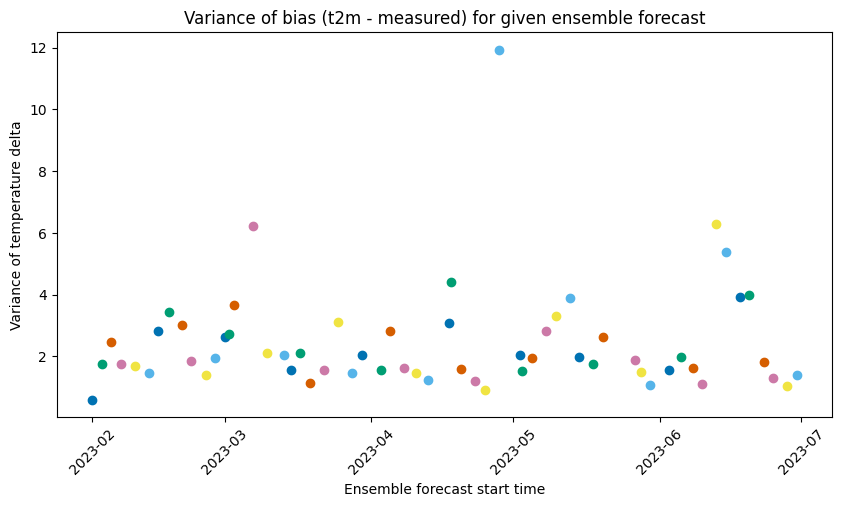

In [15]:
compute_variance_diff = partial(compute_variance, 'diff')

list_df_var = list(map(compute_variance_diff, list_df_diff))
#selects only first occurence for each ensemble forecast
diff_var_first = list(map(lambda df : df.iloc[[0]], list_df_var))
scatter_list_var(diff_var_first, on='diff var', ylabel='Variance of temperature delta',  title='Variance of bias (t2m - measured) for given ensemble forecast')

Mean and variance are looking quite constant and do not dependend on season. 
There are however a few outliers, one sample seems to be especially cold and anothers seems to have high variance (above 4). We will plot those values onto histograms to make it appear more clearly.

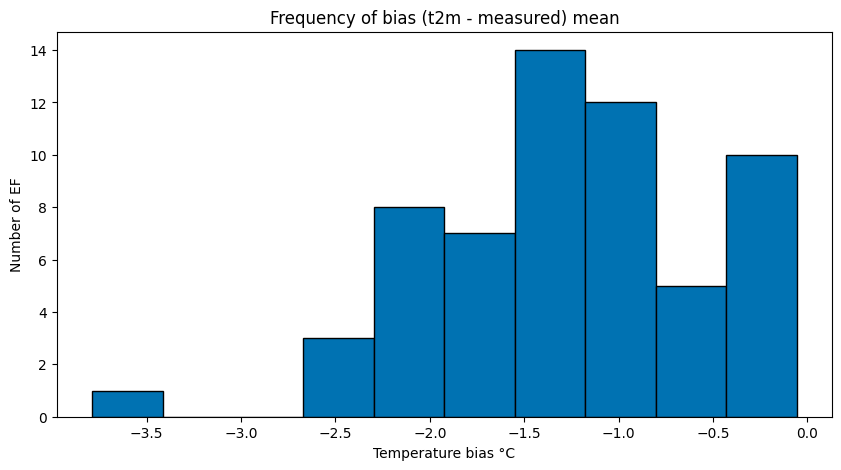

In [16]:
diff_mean = reduce(merge_df, list(map(lambda df : df.iloc[[0]], list_df_var)))

plt.figure(figsize=(10, 5))
plt.hist(diff_mean['mean_diff'], bins=10, edgecolor='black')
plt.xlabel('Temperature bias °C')
plt.ylabel('Number of EF')
plt.title('Frequency of bias (t2m - measured) mean')
plt.savefig('../Slides_img/Bias_histo.png',  bbox_inches='tight')
plt.show()

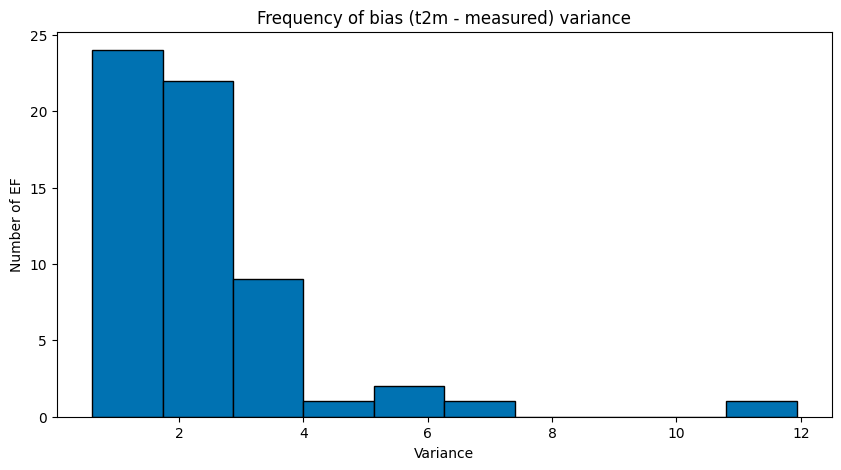

In [17]:
diff_var = reduce(merge_df, diff_var_first)

plt.figure(figsize=(10, 5))
plt.hist(diff_var['diff var'], bins=10, edgecolor='black')
plt.xlabel('Variance')
plt.ylabel('Number of EF')
plt.title('Frequency of bias (t2m - measured) variance')
plt.savefig('../Slides_img/variance_histo.png',  bbox_inches='tight')
plt.show()

We have few high variance ensemble forecasts. If we look at the time those forecast happened we can see that their are mostly during the summer. This can be explained by the heat island effect.  We will arbitrarily remove those with a variance higher than 8. We also have one forecast with mean bias +3.5. Those are outliers that will be dropped.
We should try to predict distribution and then do some hypothesis testing to remove outliers more mathematically.

In [18]:
max_var_allow = 8
high_variance = diff_var[diff_var['diff var'] > max_var_allow].index.to_list()

#Carfull with sign here when changing how bias is computed values
high_mean = diff_mean[diff_mean['mean_diff'] < -3].index.to_list()


#display list
print(f"Ensemble forecasts with variance greater than {max_var_allow}")
print(list(map(lambda df : ((df.index).strftime('%Y-%m-%d'))[0], filter(lambda df : (df['diff var'] > max_var_allow).iloc[0], diff_var_first))))

outliers = list(set(high_variance + high_mean))
print("Total outliers to remove")
outliers

Ensemble forecasts with variance greater than 8
['2023-04-28']
Total outliers to remove


[Timestamp('2023-04-28 00:00:00'), Timestamp('2023-05-02 12:00:00')]

We also mentionned earlier that the UHI is stronger at night, we will plot the difference between the forecasted temperature and the observed temperature by measurement instants.

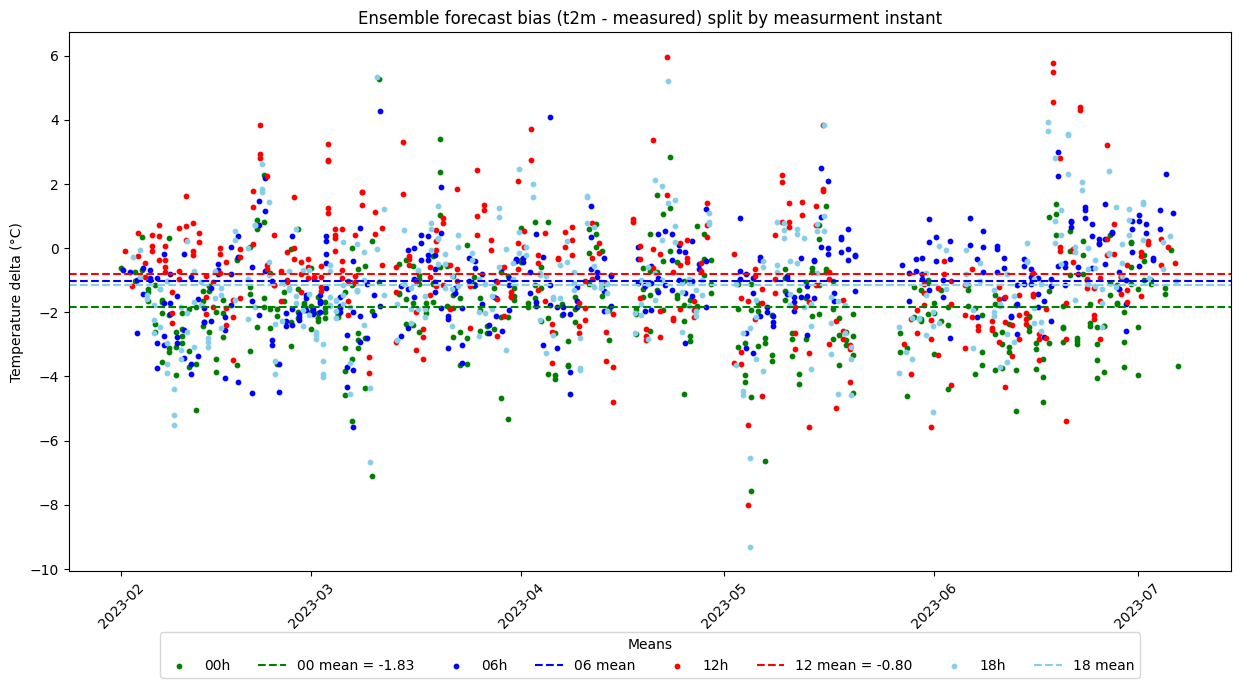

In [19]:
def compute_bias(df):
    """
        Computes bias for each lead time in a given dataframe
    """
    df['delta'] = df['t2m'] - (df['temp'] + C_0) 
    return df

def group_mean_time(df): 
    """
        Groups by mean on 'time'
    """
    return df.groupby('time').mean()
    


df_all = create_ens_fc_list()

operations = compose(group_mean_time, compute_bias , only_df)

df_all = list(map(operations, df_all))

df_all = reduce(merge_df, df_all)

df_all = df_all.reset_index()
df00 = df_all[df_all['time'].dt.time == pd.Timestamp('00:00:00').time()]
df06 = df_all[df_all['time'].dt.time == pd.Timestamp('06:00:00').time()]
df12 = df_all[df_all['time'].dt.time == pd.Timestamp('12:00:00').time()]
df18 = df_all[df_all['time'].dt.time == pd.Timestamp('18:00:00').time()]

plt.figure(figsize=(15, 7))
plt.scatter(df00['time'], df00['delta'], label='00h', color="green", s=10)
plt.axhline(y=df00['delta'].mean(), color='green', linestyle='--', label=f"00 mean = {df00['delta'].mean():.2f}")
plt.scatter(df06['time'], df06['delta'], label='06h', color="blue", s=10)
plt.axhline(y=df06['delta'].mean(), color='blue', linestyle='--', label='06 mean')
plt.scatter(df12['time'], df12['delta'], label='12h', color="red", s=10)
plt.axhline(y=df12['delta'].mean(), color='red', linestyle='--', label=f"12 mean = {df12['delta'].mean():.2f}")
plt.scatter(df18['time'], df18['delta'], label='18h', color="skyblue", s=10)
plt.axhline(y=df18['delta'].mean(), color='skyblue', linestyle='--', label='18 mean')
plt.ylabel('Temperature delta (°C)')
plt.title('Ensemble forecast bias (t2m - measured) split by measurment instant')
plt.legend(title="Means", loc='upper center', bbox_to_anchor=(0.5, -0.10), ncols=8)

plt.xticks(rotation=45)
plt.savefig('../Slides_img/Bias_Measurement_Instant.png',  bbox_inches='tight')

plt.show()

We can indeed see here that the observed temperatures seem to be relatively warmer at night, the measured temperature seems to be closer to the observed temperature at noon and both middle measurements (6h and 18h) are relatively close together.
What we can also see is that during the summer months it tends to be even warmer

We will encode this categorical data by using cyclical encoding. We will also add wind_speed as a feature as well as lead time.

In [20]:
def add_features_uhi(df):
    """ 
        Adds all features required for uhi prediction
    """
    df = df.reset_index()
    df['temp'] = df['temp'] + C_0
    df['bias'] = (df['temp'] + C_0) - df['t2m']
    df['wind_speed'] = np.sqrt(df['v10'] ** 2 + df['u10'] ** 2)
    df['time'] = pd.to_datetime(df['time'])
    df['sin_hour'] = np.sin(2 * np.pi * df['time'].dt.hour / 24)
    df['cos_hour'] = np.cos(2 * np.pi * df['time'].dt.hour / 24)
    df = df.assign(leadtime=lambda x: x.index * 6)
    return df

df_analysis_list = create_ens_fc_list()
operations = compose(add_features_uhi, group_mean_time , only_df)
df_analysis_list = list(map(operations, df_analysis_list))

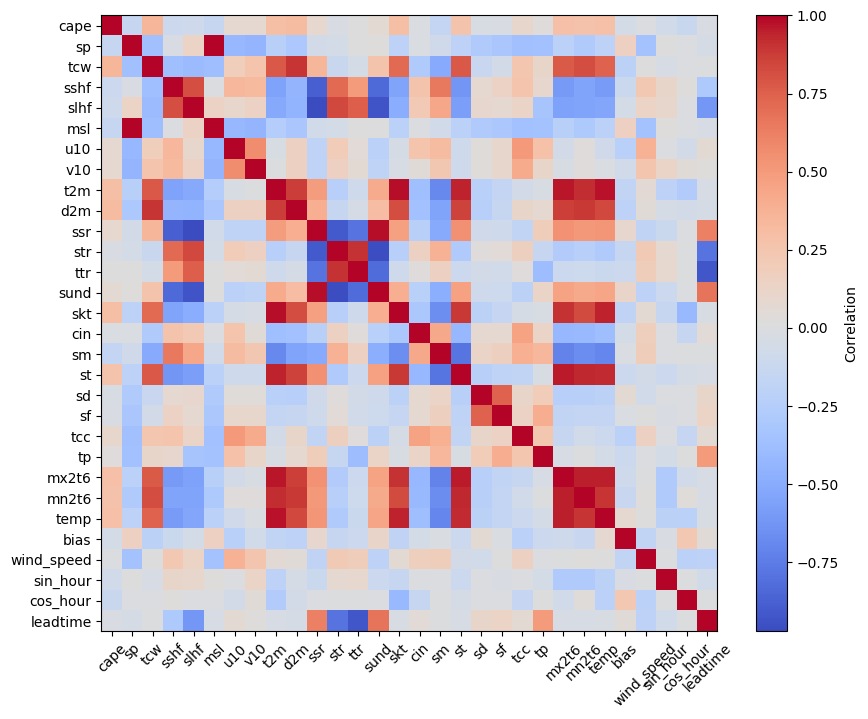

In [21]:
def display_corr_matrix(df):
    corr_matrix = df.corr() 
    plt.figure(figsize=(10, 8))
    plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest') 
    plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
    plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
    plt.colorbar(label='Correlation')
    plt.show()

df_analysis_corr = reduce(merge_df, df_analysis_list).drop(columns=['number', 'latitude', 'longitude', 'time'])
display_corr_matrix(df_analysis_corr)

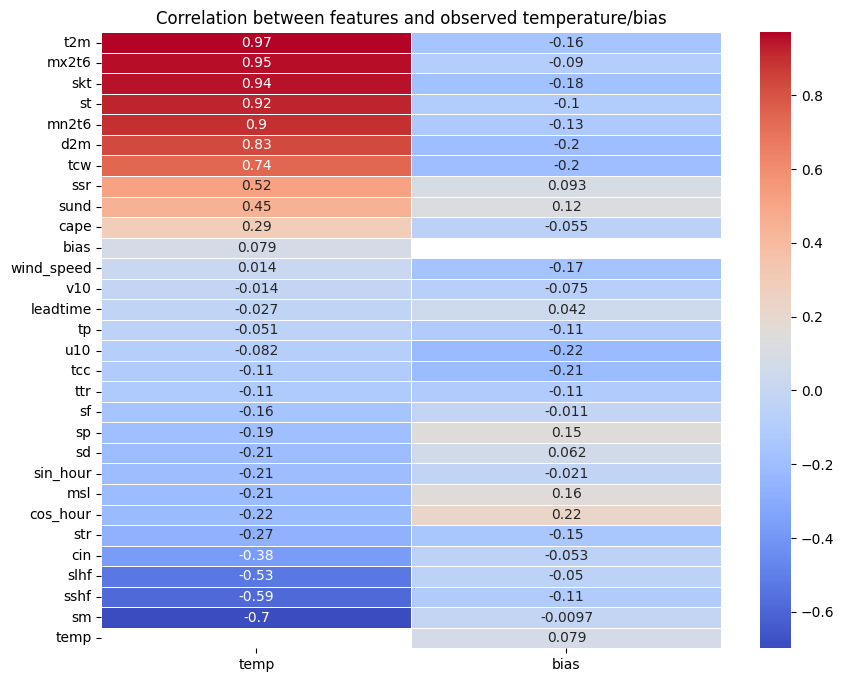

In [22]:
correlations_temp = df_analysis_corr.corr()['temp'].drop('temp')
correlations_delta = df_analysis_corr.corr()['bias'].drop('bias')
temp_corr_df = pd.DataFrame({'temp': correlations_temp, 'bias': correlations_delta})
temp_corr_df = temp_corr_df.sort_values(by=temp_corr_df.columns[0], ascending=False)
plt.figure(figsize=(10, 8))
sns.heatmap(temp_corr_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation between features and observed temperature/bias')
plt.savefig('../Corr_Matrices.png',  bbox_inches='tight')
plt.show()

Without surprise we can see from the correlation matrix that the features from the ensemble forecast that are highly correlated with the vlinder temperature are those measuring some kind of temperature (skt, t2m, d2m, mx2t6, mn2t6,..). 
But those features are also heavily correlated with each other as they represent the same thing. They therefore might not convey usefull additional information.

Having correlated features is called multicollinearity. 

Having multicollinearity is an issue for certain ml models, and not for others. However removing multicollinearity helps with explanability of our models. [src](https://hackernoon.com/multicollinearity-and-its-importance-in-machine-learning).

The first non temperature related temperature is `tcw` (= total column water). Soil moisture (`sm`) is also an interesing negative value.

This only shows linear correlation. We will compute mutual information to try to find non linear relations.

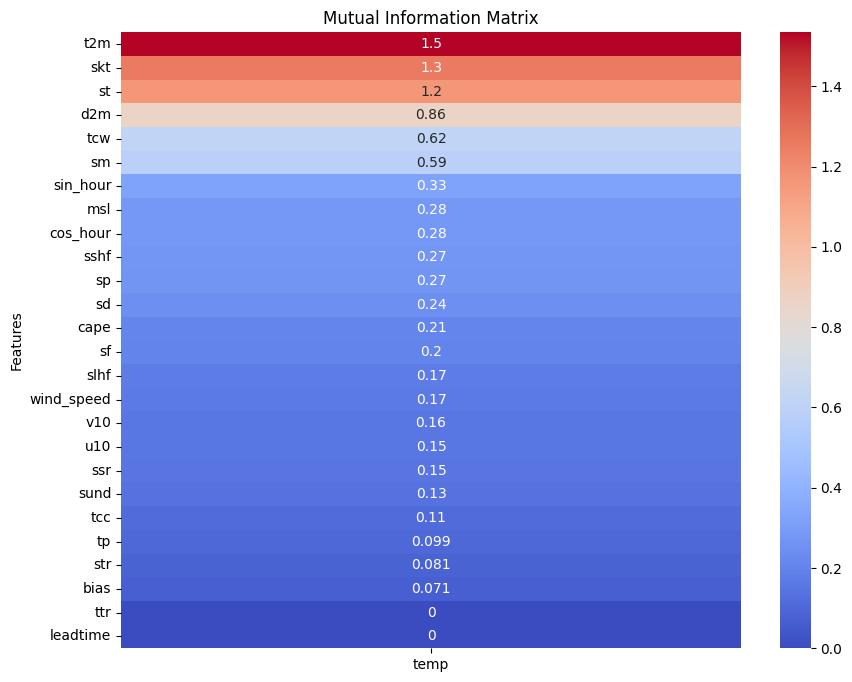

In [23]:
df_mutual_info = df_analysis_corr.drop(columns=['temp', 'cin', 'mx2t6', 'mn2t6'])
mutual_info_temp = mutual_info_regression(df_mutual_info, df_analysis_corr['temp'])

df_mutual_info = pd.DataFrame({'temp': mutual_info_temp}, index=df_mutual_info.columns).sort_values(by='temp', ascending=False)
plt.figure(figsize=(10, 8))
sns.heatmap(df_mutual_info, annot=True, cmap="coolwarm")
plt.title("Mutual Information Matrix")
plt.ylabel("Features")
plt.show()

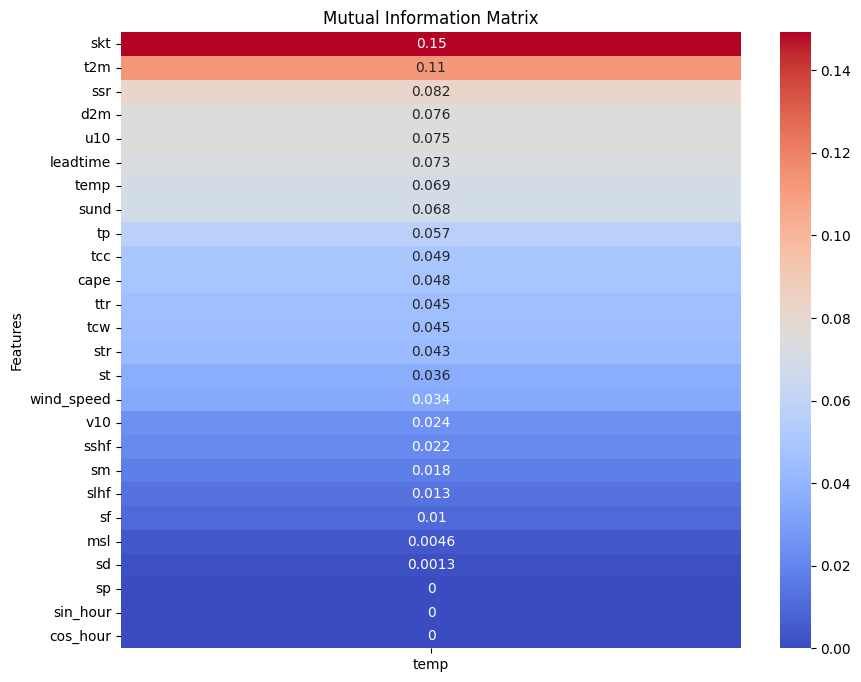

In [24]:
df_mutual_info = df_analysis_corr.drop(columns=['bias', 'cin', 'mx2t6', 'mn2t6'])
mutual_info_bias = mutual_info_regression(df_mutual_info, df_analysis_corr['bias'])

df_mutual_info = pd.DataFrame({'temp': mutual_info_bias}, index=df_mutual_info.columns).sort_values(by='temp', ascending=False)
plt.figure(figsize=(10, 8))
sns.heatmap(df_mutual_info, annot=True, cmap="coolwarm")
plt.title("Mutual Information Matrix")
plt.ylabel("Features")
plt.show()

Mutual information does not dive much more information

# Splitting Train, Validation and Test sets

As we want to train multiple models to see which has the best outcomes we want to split our data. We will do so by keeping ensemble forecasts together by starting date. Some ensemble forecast will be used to train the models, other to validate and a final ensemble forecast will be used to do the final assessment. 

However we might face data leakage if we do random splitting as we have overlapping forecasts. This means that the same target variable ('t2m') might end up in a training sample and in a test sample. To avoid this we split on time periods, keeping forecasts together on time.

As no pattern seems to appear with time we split the data chronologically (x first % go into train, following y% into validation and last z% into test set). We then remove overlapping values at each intersection to avoid data leakage. Selecting chronologically limits the number of overlapping values we need to drop.

In [25]:
def generate_tuple(df):
    """
        Functions acting on dataframes (like one creating) UHI features 
        returns only a dataframe, but all other function need a (date, df) tuple
        We need a function to add the date again
    """
    return (df['time'][0], df)

dfs = create_ens_fc_list()

to_remove = outliers + [not_enough_info]



"""
    In the ensemble forecast list (dfs), tp[0] are timestamp objects, not strings => to_remove list should contain
    timestamp objects
"""
cleared = list(filter(lambda tp : tp[0] not in to_remove, dfs))

# add UHI features to dataframes
operations = compose(generate_tuple, add_features_uhi, group_mean_time , only_df)

cleared = list(map(operations, cleared))

assert len(cleared) + len(to_remove) == len(dfs), f"cleared list + remove list is not the same length as inital list: {len(cleared)} + {len(to_remove)} != {len(dfs)}"

def select_chronologically(dfs_list, train_p=0.6, val_p=0.2):
    """
        Selects in order of appearance: first 'train_p'% values are going into train set, following `val_p`% are going into train set 
        and rest goes into test set
        Might not be exatly split as some dataframe contain different number of observations after data cleaning
        TODO: We have a lot of overlapping data in the beggining (from 1-03 to 3-03), is this an issue?
    """
    nb_elem = len(dfs_list)
    train_index_max = int(nb_elem * train_p)
    
    train_set = dfs_list[: train_index_max]
    
    val_index_max = int(nb_elem * (train_p + val_p))
    val_set = dfs_list[train_index_max: val_index_max]
    
    test_set = dfs_list[val_index_max:]

    contains_common_elements = set(map(only_date, train_set)) & set(map(only_date, val_set)) & set(map(only_date, test_set))
    assert not contains_common_elements, "train, validation and test contain same ensemble forecast"

    return (train_set,val_set,test_set)

def select_randomly(dfs_list, train_p=0.6, val_p=0.2):
    """
        Splits randomly values from from given input dataframe list into (train_set, val_set, test_set)
        TODO: might not be exatly as dataframe contain different number of observations after data cleaning
        NOTE: not used anyway
    """
    nb_elem = len(dfs_list)
    
    nb_train_elements = int(nb_elem * train_p)
    train_set = sorted(random.sample(dfs_list, nb_train_elements), key=lambda x : x[0])

    #list of not selected elements
    rest = sorted([tp for tp in dfs if tp not in train_set], key=lambda x : x[0])

    nb_val_elements = round(nb_elem * val_p)
    
    validation_set = sorted(random.sample(rest, nb_val_elements), key=lambda x : x[0])

    test_set = sorted([tp for tp in rest if tp not in validation_set], key=lambda x : x[0])

    contains_common_elements = set(map(only_date, train_set)) & set(map(only_date, validation_set)) & set(map(only_date, test_set))
    assert not contains_common_elements, "train, validation and test contain same ensemble forecast"
    return (train_set, validation_set, test_set)

def get_unique_timestamps_set(df_list):
    """
        returns set of all timestamps of the list of dataframe passed as argument
    """
    operations = compose(lambda np_arr: np_arr.tolist(), lambda df: df['time'].unique(), only_df)
    return set(reduce(operator.concat, list(map(operations, df_list))))

def select_unique(dfs_list, train_p=0.6, val_p=0.2): 
    """
        We need to make sure that no common dates are appearing in train, validation and test set
        1. extract all unique time stamps from train, validation and test set
        2. As we select chornologically we need to check only if there is overlapping data between train-val and val-test
        3. Remove overlapping data from the earliest dataframe, (=> from train in train-val and from val in val-test). 
            -> This favors that is a bit more recent in the 
    """
    train, val, test = select_chronologically(dfs_list, train_p, val_p)
    operations = compose(lambda np_arr: np_arr.tolist(), lambda df: df['time'].unique(), only_df)
    
    #list containing sublists with all unique time stamps within a given dataframe
    unique_dates_train = get_unique_timestamps_set(train)
    uniques_dates_val = get_unique_timestamps_set(val)
    uniques_dates_test = get_unique_timestamps_set(test)

    conflict_train_val = unique_dates_train & uniques_dates_val
    conflict_val_test = uniques_dates_val & uniques_dates_test
    
    # Removes conflicting values from train and validation sets
    train = list(map(lambda tp: (tp[0], tp[1][~tp[1]['time'].isin(list(conflict_train_val))]), train))
    val = list(map(lambda tp: (tp[0], tp[1][~tp[1]['time'].isin(list(conflict_val_test))]), val))
    
    return (train, val, test)

train_set, val_set, test_set = select_unique(cleared)

unique_dates_train = get_unique_timestamps_set(train_set)
unique_dates_val = get_unique_timestamps_set(val_set)
unique_dates_test = get_unique_timestamps_set(test_set)

# making sure that no timestamp exists in muliple sets
assert len(cleared) == len(train_set) + len(val_set) + len(test_set), f"Inital list and sum of generated list do not have the same number of elements {len(cleared)} != {len(train_set)} + {len(val_set)} + {len(test_set)}"
assert len(unique_dates_train & unique_dates_val) == 0, f"Train and validation sets contain same dates {unique_dates_train & unique_dates_val}"
assert len(unique_dates_val & unique_dates_test) == 0, f"Val and Test sets contain same dates {unique_dates_val & unique_dates_test}"
assert len(unique_dates_train & unique_dates_test) == 0, f"Train and Test sets contain same dates {unique_dates_train & unique_dates_test}"

In [26]:
#Display columns that have NaN values and percentage of NaN values
def nan_info(df):
    for column in which_col_nan(df):
        nan_percent = get_nan_percent(df[column], df.shape[0])
        print(f"{column} has {nan_percent * 100:.2f} % of NaN values" )
        
#Returns list of Columns that have nan values
def which_col_nan(df):
    return df.columns[df.isna().any()].tolist()

def get_nan_percent(df_col, df_entries):
    return df_col.isna().sum() / df_entries

nan_info(reduce_df(train_set))

cin has 36.30 % of NaN values
mx2t6 has 3.47 % of NaN values
mn2t6 has 3.47 % of NaN values


We can see that cin has a large amount of NaN values and mx2t6 and mn2t6 have smaller amount, we will definitevely drop cin, but we could extrapolate mx2t6 it appears to be interesting.

Most of the values are actually not really relevant and our models will mainly focus on `t2m` feature

In [27]:
# Returns list of columns who have a number of unique features = 1 (=> all the same values)
# from https://studymachinelearning.com/pandas-how-to-remove-dataframe-columns-with-constant-same-values/
def constant_value_features_columns(df):
    return [e for e in df.columns if df[e].nunique() == 1]

def remove_cst_values(df):
    to_keep = [e for e in df.columns if e not in constant_value_features_columns(df)]
    return df[to_keep]

def remove_nan_values(df):
    na_cols = which_col_nan(df)
    return df.drop(columns=na_cols, axis=1)

def clean_dfs(df_lst):
    """ 
        Takes in a LIST of [(timestamp, dataframes)]
        Applies above mentionned transformations to a list of dataframes
            - Removes columns with all const values
            - Removes columns with NaN values
        Returns only one dataframe 
    """
    reduce_merge_train = reduce(merge_df, map(only_df, df_lst))
    return clean_one(reduce_merge_train)

def clean_one(df):
    """
        Takes in a dataframe, applies transformations
        - Removes columns with all const values
        - Removes columns with NaN values
        Returns cleaned dataframe
    """
    transform_operations = compose(remove_cst_values, remove_nan_values)
    cleaned_df = transform_operations(df)
    return cleaned_df

Those clean functions are not really usefull in practice as we will mostly select features that are always complete and not constant.

# Training Models

For each model we will:
1. Clean and transform the train data to prepare it for the model
3. Fit the model
4. Try the model on validation data.
    - We might need to transform validation data aswell
    - Compute the corrected forecast values and and take the mean. We can then compare this mean to our measured temperature on the same interval

Each model will have to handle the list of dataframe, select a subset of features that it will train on. Its will also need to do hyperparameter tuning and transform the dataframe on which the correction will happen. Even if most of those operations are quite similar for each model it its best to encapsulate them in classes. This will make the code a bit more readable. We will have one abstract class representing a general model. Each model will then inherit from that class.

In [28]:
class Model(ABC): 
    
    @property
    @abstractmethod
    def name(self):
        pass

    @property
    @abstractmethod
    def model(self):
        pass
    
    @abstractmethod
    def transform_list(self, df_list: list):
        pass

    @abstractmethod
    def transform_correct_pred(self, df):
        pass
    
    @abstractmethod
    def train_model(self, df):
        pass

    @abstractmethod
    def predict(self, df):
        pass

def correct_fc(df, model: Model):
    """
        Returns dataframe with 
        - original t2m
        - measured temp
        - corrected t2m
    """
    original = df[['time', 't2m']]
    measured = df[['time', 'temp']]
    corrected = df[['time', 't2m']]
    corrected['t2m'] = model.predict(df)
    return (original, measured, corrected)

def eval_metrics(set, model_list):
    """
        Takes in set on which to compute evaluation metrics and list of models to test
    """

    best = (None, None)
    
    for model in model_list: 
        
        # will hold each rmse for individual ensemble forecasts
        rmse_lst = np.array([])
        # will hold bias of original ensemble forecast
        bias_og_lst = np.array([]) 
        # will hold bias of corrected ensemble forecast
        bias_corr_lst = np.array([])
        
        for element in set:
            df = element[1]
            original, measured, corrected = correct_fc(df, model)
            
            y_true = measured['temp'].values
            y_corrected = corrected['t2m'].values
            y_original = original['t2m'].values
            
            bias_original = np.sum(y_original - y_true) / len(y_true)
            bias_og_lst = np.append(bias_og_lst, bias_original)
            
            bias_corrected = np.sum(y_corrected - y_true) / len(y_true)
            bias_corr_lst = np.append(bias_corr_lst, bias_corrected)

            rmse = root_mean_squared_error(y_true, y_corrected)
            rmse_lst = np.append(rmse_lst, rmse)

        mean_rmse = np.mean(rmse_lst)
        mean_bias_og = np.mean(bias_og_lst)
        mean_bias_corrected = np.mean(bias_corr_lst)
    
        print(model.name)
        print("-> On individual sets:")
        print('  Average model rmse:', round(mean_rmse, 2), '.')
        print('  Average baseline bias: ', round(mean_bias_og, 2), 'degrees.')
        print('  Average corrected bias:', round(mean_bias_corrected, 2), 'degrees.')    
        improvement_baseline = 100 * (abs(mean_bias_og) - abs(mean_bias_corrected)) / abs(mean_bias_og)
        print('  Improvement over baseline:', round(improvement_baseline, 2), '%.')
        print('=======')
        
        if (best[0] == None):
            best = (mean_rmse, model)
        #if current rmse is worse than the one stored in best, we update
        elif (best[0] > mean_rmse):
            best = (mean_rmse, model) 
        #return best model
    
    return best[1]

In [29]:
model_list = []

We will store all models as tuples ("modelname", model, transform function) inside the model_list.
This is done to make it easier later to evaluate the different models

## Linear Regression
"Least-squares regression is applied on training data to estimate a linear relationship between predictions and corresponding observations" from _Vannitsem, S., Wilks, D. S., & Messner, J. W. (Elsevier). (2018). Statistical Postprocessing of Ensemble Forecasts_

We will first fit a linear regression with only 't2m' as a feature.

We will then make a second linear regression with 't2m' and 'tcw' as its the second highest correlated value that is not a temperature.

### 1. Only t2m feature

In [30]:
class linearReg(Model): 
    def __init__(self):
        self._name = "Linear Regression"
        self._model = LinearRegression()

    @property
    def name(self):
        return self._name

    @property
    def model(self):
        return self._model
    
    def transform_list(self, df_list):
        df = reduce_df(df_list)
        df = df[['t2m', 'temp', 'time']]
        
        # Line to comment out group indentical values by mean
        #df = df.groupby('time').mean()
        df = df.drop_duplicates(subset='time', keep='last')
        
        df.reset_index(inplace=True)
        df.drop(columns=['index'], inplace=True)
        df.to_csv('temp.csv')
        return df

    def transform_correct_pred(self, df):
        """
            Expects as input ensemble forecast
            Returns selected features used in prediction
            Used when calling predict. 
        """
        return df['t2m'].values.reshape(-1, 1)
    
    @timer
    def train_model(self, df):
        """
            Expects result from transform_list()
        """
        X = df['t2m'].values.reshape(-1, 1)
        y = df['temp'].values.reshape(-1, 1)
        self._model.fit(X, y)
        return self._model

    def predict(self, df):
        """
            Expects ensemble forecast dataframe
        """
        return self.model.predict(self.transform_correct_pred(df))

    def __str__(self):
        return f"Model(Name={self._name})"

lr = linearReg()

lr.train_model(lr.transform_list(train_set))

eval_metrics(train_set, [lr])
eval_metrics(val_set, [lr])

model_list.append(lr)

Finished train_model() in 0.0041 secs for 301 elements
Linear Regression
-> On individual sets:
  Average model rmse: 1.44 .
  Average baseline bias:  -1.14 degrees.
  Average corrected bias: -0.13 degrees.
  Improvement over baseline: 88.97 %.
Linear Regression
-> On individual sets:
  Average model rmse: 1.85 .
  Average baseline bias:  -1.4 degrees.
  Average corrected bias: -1.09 degrees.
  Improvement over baseline: 22.37 %.


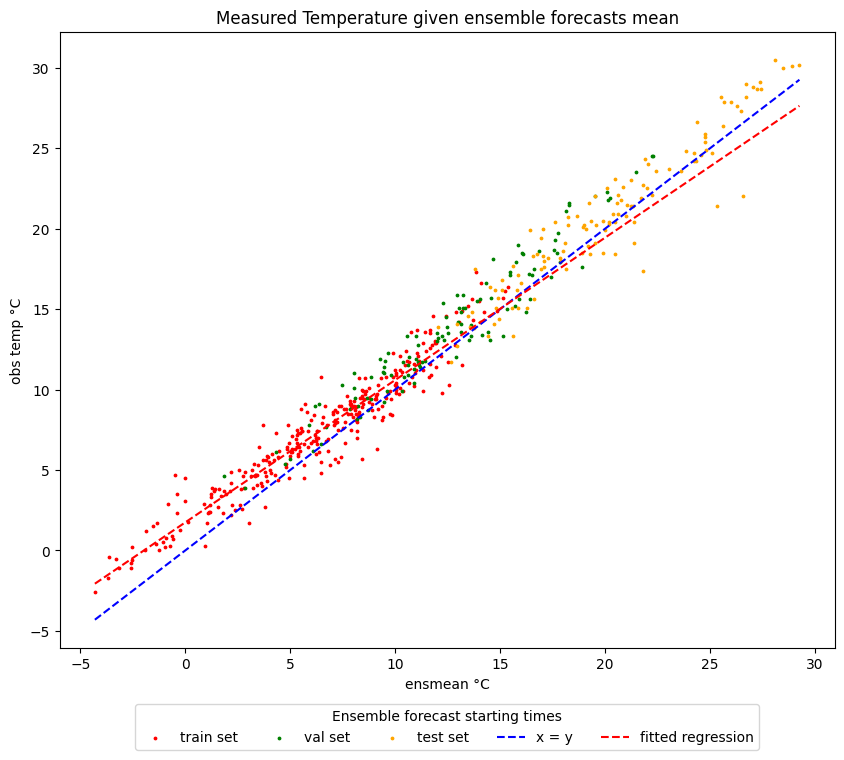

In [31]:
train = lr.transform_list(train_set)
val = lr.transform_list(val_set)
test = lr.transform_list(test_set)

x = np.linspace(min(train['t2m'] - C_0), max(test['t2m'] - C_0))
y = x

slope = lr.model.coef_[0]
intercept = lr.model.intercept_

line = slope * np.linspace(min(train['t2m']), max(test['t2m'])) + intercept - C_0

plt.figure(figsize=(10, 8))
plt.scatter(train['t2m'] - C_0, train['temp'] - C_0, marker='o', s=3, label="train set", color="red")
plt.scatter(val['t2m'] - C_0, val['temp'] - C_0, marker='o', s=3, label="val set", color="green")
plt.scatter(test['t2m'] - C_0, test['temp'] - C_0, marker='o', s=3, label="test set", color="orange")


plt.plot(x , y, linestyle='--', color='blue', label='x = y')
plt.plot(x , line, linestyle='--', color='red', label='fitted regression')
plt.legend(title="Ensemble forecast starting times", loc='upper center', bbox_to_anchor=(0.5, -0.08), ncols=6)
plt.xlabel("ensmean °C")
plt.ylabel("obs temp °C")
plt.title('Measured Temperature given ensemble forecasts mean')
plt.savefig('../Measured_Mean.png',  bbox_inches='tight')
plt.show()

We can actually see that our linear regression is going to perform quite poorly when temperatures are higher than 5 degrees and is going to do barely better than the ensemble mean. This might because there is a higher temperature difference at lower temperatures (probably at night) which makes our regression tilt to the right. We will try to reduce this bias by trying other regression techniques such as Ridge and Lasso.

### 1. Multiple Linear Regression 

Instead of only using the ensemble mean to correct our temperatures we will add multiple other variables that also correlate highly with our target temperature 

In [32]:
class MultipleLinearReg(Model): 
    def __init__(self, features=['t2m', 'tcw', 'sm']):
        self._name = "Multiple Linear Regression"
        self._model = LinearRegression()
        self._selected_features = features;
    
    @property
    def name(self):
        return self._name

    @property
    def model(self):
        return self._model
    
    def transform_list(self, df_list):
        df = reduce_df(df_list)
        df = df[['temp', 'time'] + self._selected_features]
        #df = df.groupby('time').mean()
        df = df.drop_duplicates(subset='time', keep='last')
        df.set_index('time', inplace=True)
        return df

    def transform_correct_pred(self, df):
        """
            Expects as input ensemble forecast
            Returns selected features used in prediction
            Used when calling predict. 
        """
        return df[self._selected_features]

    @timer
    def train_model(self, df):
        """
            Expects result from transform_list()
        """
        X = df[self._selected_features]
        y = df['temp'].values.reshape(-1, 1)
        self._model.fit(X, y)
        return self._model

    def predict(self, df):
        """
            Expects ensemble forecast dataframe
        """
        return self.model.predict(self.transform_correct_pred(df))

    def get_features(self):
        df = pd.DataFrame({'Index': self._selected_features, 'Value': self.model.coef_[0]})
        df.set_index('Index', inplace=True)
        return df

m_lr = MultipleLinearReg()

m_lr.train_model(m_lr.transform_list(train_set))

eval_metrics(train_set, [m_lr])
eval_metrics(val_set, [m_lr])

m_lr.get_features()

Finished train_model() in 0.0016 secs for 301 elements
Multiple Linear Regression
-> On individual sets:
  Average model rmse: 1.44 .
  Average baseline bias:  -1.14 degrees.
  Average corrected bias: -0.13 degrees.
  Improvement over baseline: 88.83 %.
Multiple Linear Regression
-> On individual sets:
  Average model rmse: 1.83 .
  Average baseline bias:  -1.4 degrees.
  Average corrected bias: -1.09 degrees.
  Improvement over baseline: 22.51 %.


Value
Index          
t2m    0.902630
tcw   -0.023075
sm     0.000508

What is interesting to note is that even if total cloud cover and soil moisture have a high correlation with observed temperature, their coefficient is really low. This indicates high multicolineary. We should try to find better variables.

We can again see that the best approach is to keep the latest dates for prediction. It does however not do better than simple linear regression.

Multiple Linear Reg - No duplicate dropping
- mse: 4.782626733031569
- mae: 1.7327302231447639
- r2: 0.6861883068615133

Multiple Linear Reg - Grouping by Mean
- mse: 3.5594229215412994
- mae: 1.5204834991513527
- r2: 0.7997206566872209

Multiple Linear Reg - Latest
- mse: 2.653708732790542
- mae: 1.2980285143972838
- r2: 0.8506828061565288

I choose new features here, instead of selecting values that correlated high with our observed temperature, I added the features who correlated the highest with our bias (t2m - obs)

In [33]:
m_lr_v2 = MultipleLinearReg(['t2m', 'cos_hour', 'u10', 'tcc'])
m_lr_v2.train_model(m_lr_v2.transform_list(train_set))

model_list.append(m_lr_v2)

corr = m_lr_v2.predict(m_lr_v2.transform_list(val_set))

eval_metrics(train_set, [m_lr_v2])
eval_metrics(val_set, [m_lr_v2])

m_lr_v2.get_features()

Finished train_model() in 0.0010 secs for 301 elements
Multiple Linear Regression
-> On individual sets:
  Average model rmse: 1.43 .
  Average baseline bias:  -1.14 degrees.
  Average corrected bias: -0.12 degrees.
  Improvement over baseline: 89.6 %.
Multiple Linear Regression
-> On individual sets:
  Average model rmse: 1.54 .
  Average baseline bias:  -1.4 degrees.
  Average corrected bias: -0.6 degrees.
  Improvement over baseline: 57.19 %.


Value
Index             
t2m       0.940088
cos_hour  0.343702
u10      -0.052579
tcc      -0.005655

## Lasso Regression

https://www.ibm.com/topics/ridge-regression

As mentionned before, most of the values that have a high correlation with target temperature are also correlated with each other. In order to reduce this multicollinearity we can use regularization to improve our forecast.

We can either use Ridge or Lasso.

Lasso (=L1) will reduce certain features to 0 and thus perform selection. 

Ridge (=L2) will shrink down certain extreme values (but they wont be equal to 0 -> there is no feature selection).

Ridge is usefull if all our features are potentially relevant. However we already saw that there is high multicollinearity. We will use lasso regression as we have a high-dimensional set. It will perform feature selection for us.

In [34]:
class LassoReg(Model): 
    def __init__(self, features=['t2m', 'cos_hour', 'u10']):
        self._name = "Lasso Reg"
        # default iter is 1_000
        self._model = Lasso(max_iter = 10000)
        self._selected_features = features;
        
    @property
    def name(self):
        return self._name

    @property
    def model(self):
        return self._model
    
    def transform_list(self, df_list):
        df = reduce_df(df_list)
        df = df[['temp', 'time'] + self._selected_features]
        df = df.drop_duplicates(subset='time', keep='last')
        df.set_index('time', inplace=True)
        return df

    def transform_correct_pred(self, df):
        """
            Expects as input ensemble forecast
            Returns selected features used in prediction
            Used when calling predict. 
        """
        df = df[self._selected_features] 
        return df

    @timer
    def train_model(self, df):
        """
            Expects result from transform_list()
        """
        X = df[self._selected_features]
        y = df['temp'].values.reshape(-1, 1)
        self._model.fit(X, y)
        return self._model

    def predict(self, df):
        """
            Expects ensemble forecast dataframe
        """
        return self.model.predict(self.transform_correct_pred(df))

    def get_features(self):
        df = pd.DataFrame({'Index': self._selected_features, 'Value': self.model.coef_})
        df.set_index('Index', inplace=True)
        return df

    @track_emissions
    @timer
    def tune(self, df):
        """
            Does hyper param tuning. replaces the model in the class with the tuned model
        """
        param_grid = {'alpha': [0.00001, 0.0001, 0.001 ,0.1, 1.0, 10.0, 100.0]}
        X = df[self._selected_features]
        y = df['temp'].values.reshape(-1, 1)
        grid_search = GridSearchCV(self._model, param_grid, cv=5)
        grid_search.fit(X, y)
        #self._model = Lasso(alpha=grid_search.best_params_['alpha'])
        self._model = grid_search.best_estimator_

lasso = LassoReg(features=['t2m', 'cos_hour', 'tcc', 'u10', 'd2m', 'tcw', 'sm', 'msl', 'sshf', 'ssr', 'skt', 'v10', 'st', 'sin_hour', 'sund', 'ttr']) #, 'skt', 'v10', 'leadtime', 'wind_speed'

lasso.tune(lasso.transform_list(train_set))

eval_metrics(train_set, [lasso])
eval_metrics(val_set, [lasso])

model_list.append(lasso)

lasso.get_features()

[codecarbon INFO @ 12:55:37] [setup] RAM Tracking...
[codecarbon INFO @ 12:55:37] [setup] GPU Tracking...
[codecarbon INFO @ 12:55:37] No GPU found.
[codecarbon INFO @ 12:55:37] [setup] CPU Tracking...
[codecarbon WARNING @ 12:55:37] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:55:37] CPU Model on constant consumption mode: Apple M1
[codecarbon INFO @ 12:55:37] >>> Tracker's metadata:
[codecarbon INFO @ 12:55:37]   Platform system: macOS-14.0-arm64-arm-64bit
[codecarbon INFO @ 12:55:37]   Python version: 3.11.7
[codecarbon INFO @ 12:55:37]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 12:55:37]   Available RAM : 8.000 GB
[codecarbon INFO @ 12:55:37]   CPU count: 8
[codecarbon INFO @ 12:55:37]   CPU model: Apple M1
[codecarbon INFO @ 12:55:37]   GPU count: None
[codecarbon INFO @ 12:55:37]   GPU model: None
[codecarbon WARNING @ 12:55:37] Unable to access geographical location. Using 'Canada' as the default value - Exception : HTTPSConnectionPool

Finished tune() in 0.2964 secs for 301 elements
Lasso Reg
-> On individual sets:
  Average model rmse: 1.53 .
  Average baseline bias:  -1.14 degrees.
  Average corrected bias: 0.45 degrees.
  Improvement over baseline: 60.28 %.
Lasso Reg
-> On individual sets:
  Average model rmse: 1.49 .
  Average baseline bias:  -1.4 degrees.
  Average corrected bias: 0.09 degrees.
  Improvement over baseline: 93.74 %.


Value
Index                 
t2m       9.777381e-01
cos_hour  2.495885e-01
tcc      -4.901333e-03
u10      -3.935857e-02
d2m      -5.535887e-02
tcw       9.365422e-03
sm        4.283987e-03
msl       1.025626e-04
sshf     -1.334174e-07
ssr      -7.206824e-08
skt      -6.357459e-02
v10       8.857599e-02
st        1.251714e-01
sin_hour  1.190862e-01
sund      2.040090e-05
ttr      -1.874837e-08

Lasso does a bit better than linear regression

## Random Forest Regression

In [35]:
class RandomForest(Model): 
    def __init__(self, name="Random Forest", features=['t2m', 'cos_hour', 'u10', 'tcc']):
        #params.pop('random_state')
        self._name = name
        self._model = RandomForestRegressor(random_state=42)
        self._selected_features = features;
        # We use default hyper parameters at the start
        # They will be changed later by doing hyper param tuning
        # self._params = params
        
    @staticmethod
    def select_best(df, nb=5):
        selector = SelectKBest(k=nb, score_func=mutual_info_regression)
        df = clean_one(df)
        y = df['temp'].values.reshape(-1, 1)
        X = df.drop(columns=['time', 'temp', 'bias'])
        X_selected = selector.fit_transform(X, y.ravel())
        cols_idxs = selector.get_support(indices=True)
        X = X.iloc[:,cols_idxs].reset_index().drop(columns='index')
        selected_features = X.columns.to_list()
        return selected_features

    @property
    def name(self):
        return self._name

    @property
    def model(self):
        return self._model
    
    def transform_list(self, df_list):
        df = reduce_df(df_list)
        df = df[['temp', 'time'] + self._selected_features]
        df = df.drop_duplicates(subset='time', keep='last')
        df.set_index('time', inplace=True)
        return df
        
    #def transform_list_keep_all(self, df_list):
    
    def transform_correct_pred(self, df):
        """
            Expects as input ensemble forecast
            Returns selected features used in prediction
            Used when calling predict. 
        """
        return df[self._selected_features] 

    def train_model(self, df):
        """
            Expects result from transform_list()
        """
        X = df[self._selected_features]
        y = df['temp'].values.reshape(-1, 1)
        self._model.fit(X, y.ravel())
        return self._model

    def predict(self, df):
        """
            Expects ensemble forecast dataframe
        """
        return self.model.predict(self.transform_correct_pred(df))

    def RFECV(self, df):
        X = df[self._selected_features]
        y = df['temp'].values.reshape(-1, 1)
        rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
        rfecv = RFECV(estimator=rf_regressor, step=1, cv=5, scoring="neg_mean_squared_error")
        rfecv.fit(X, y.ravel())
        return rfecv

    def display_feature_importance(self):
        """
            Displays features importance of our fitted model
        """
        #from https://github.com/WillKoehrsen/Data-Analysis/blob/master/random_forest_explained/Improving%20Random%20Forest%20Part%201.ipynb
        # Get numerical feature importances
        importances = list(self.model.feature_importances_)
        # List of tuples with variable and importance
        feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(self._selected_features, importances)]
        # Sort the feature importances by most important first
        feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
        # Print out the feature and importances 
        [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
        #return (selected_features)
    
    @track_emissions
    @timer
    def tune(self, df):
        """
            Is going first to perform random grid search to get and idea of a possible range.
            We will then do an exhaustive search on values around the results of random search.
            Sets internal model to best model
        """
        X = df[self._selected_features]
        y = df['temp'].values.reshape(-1, 1)
        #from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
        # nb of trees in the forest, the more the better, there is nothing restricting use to add more, this will incrementaly slow down our code.
        n_estimators = [int(x) for x in np.linspace(start = 2, stop = 200, num = 10)]
        # max depth of the tree
        max_depth = [int(x) for x in np.linspace(1, 20, num = 5)]
        max_features = [0.1, 0.3, 0.7, 1.0]
        random_grid = {'n_estimators': n_estimators,
                       'max_depth': max_depth,
                      'max_features': max_features}    
        
        random_search = RandomizedSearchCV(estimator = self.model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)
        random_search.fit(X, y.ravel())
        
        grid = random_search.best_params_
        # step size in terms of % of best_param value
        step_size = 0.1
        search_grid = {}
        for parameter, initial_value in grid.items():
            step = round(initial_value * step_size)
            new_values_before = [(initial_value - (i * step)) for i in range(1, 5)]
            new_values_after = [(initial_value + (i * step)) for i in range(1, 5)]
            new_values = new_values_before + [initial_value] + new_values_after
            search_grid[parameter] = new_values

        # if only one feature needs to be wrapped in a list
        search_grid['max_features'] = [grid['max_features']]
        grid_search = GridSearchCV(estimator = self.model, param_grid = search_grid, cv = 3, n_jobs = -1, verbose = 0)
        grid_search.fit(X, y.ravel())
        self._model = grid_search.best_estimator_
        self._params = grid_search.best_params_
        return self

rf_base = RandomForest("RF Base")
rf_base.train_model(rf_base.transform_list(train_set))
rf_base.display_feature_importance()
model_list.append(rf_base)

Variable: t2m                  Importance: 0.95
Variable: u10                  Importance: 0.02
Variable: tcc                  Importance: 0.02
Variable: cos_hour             Importance: 0.01


In [36]:
k_best = RandomForest.select_best(reduce_df(train_set), 5)
rf_k_best = RandomForest("RF k Best",k_best)
rf_k_best.train_model(rf_k_best.transform_list(train_set))
model_list.append(rf_k_best)
rf_k_best.display_feature_importance()

Variable: t2m                  Importance: 0.94
Variable: st                   Importance: 0.02
Variable: tcw                  Importance: 0.01
Variable: d2m                  Importance: 0.01
Variable: skt                  Importance: 0.01


In [37]:
eval_metrics(train_set, [rf_base])
eval_metrics(val_set, [rf_base])

eval_metrics(train_set, [rf_k_best])
eval_metrics(val_set, [rf_k_best])

RF Base
-> On individual sets:
  Average model rmse: 1.31 .
  Average baseline bias:  -1.14 degrees.
  Average corrected bias: -0.08 degrees.
  Improvement over baseline: 92.79 %.
RF Base
-> On individual sets:
  Average model rmse: 2.44 .
  Average baseline bias:  -1.4 degrees.
  Average corrected bias: -1.25 degrees.
  Improvement over baseline: 10.51 %.
RF k Best
-> On individual sets:
  Average model rmse: 1.35 .
  Average baseline bias:  -1.14 degrees.
  Average corrected bias: -0.15 degrees.
  Improvement over baseline: 86.82 %.
RF k Best
-> On individual sets:
  Average model rmse: 2.51 .
  Average baseline bias:  -1.4 degrees.
  Average corrected bias: -1.44 degrees.
  Improvement over baseline: -3.02 %.


Using a default random forest with hand selected features (\['t2m', 'cos_hour', 'u10'\]) does a better job than using k best selected, even if we used 'mutual_info_regression'. We could try Recursive Feature Elimination with Cross-Validation instead.

Optimal number of features : 19


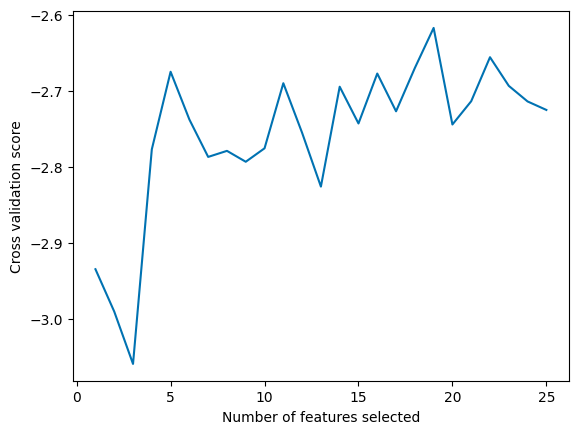

In [38]:
# Select all features
features = RandomForest.select_best(reduce_df(train_set), 25)
rfecv = RandomForest("RF tmp", features)
rfecv = rfecv.RFECV(rfecv.transform_list(val_set))

print("Optimal number of features : %d" % rfecv.n_features_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.show()

In [39]:
selected_features = np.where(rfecv.support_)[0]
selected_feature_names = [features[i] for i in selected_features]
print(selected_feature_names)

['cape', 'sp', 'tcw', 'sshf', 'slhf', 'msl', 'u10', 'v10', 't2m', 'd2m', 'ttr', 'sund', 'skt', 'sm', 'st', 'tcc', 'tp', 'wind_speed', 'cos_hour']


In [40]:
rf_rfecv = RandomForest("RF rfecv ",selected_feature_names)
rf_rfecv.train_model(rf_rfecv.transform_list(train_set))
rf_rfecv.display_feature_importance()

eval_metrics(train_set, [rf_rfecv])
eval_metrics(val_set, [rf_rfecv])

model_list.append(rf_rfecv)

Variable: t2m                  Importance: 0.93
Variable: sshf                 Importance: 0.01
Variable: st                   Importance: 0.01
Variable: tp                   Importance: 0.01
Variable: cape                 Importance: 0.0
Variable: sp                   Importance: 0.0
Variable: tcw                  Importance: 0.0
Variable: slhf                 Importance: 0.0
Variable: msl                  Importance: 0.0
Variable: u10                  Importance: 0.0
Variable: v10                  Importance: 0.0
Variable: d2m                  Importance: 0.0
Variable: ttr                  Importance: 0.0
Variable: sund                 Importance: 0.0
Variable: skt                  Importance: 0.0
Variable: sm                   Importance: 0.0
Variable: tcc                  Importance: 0.0
Variable: wind_speed           Importance: 0.0
Variable: cos_hour             Importance: 0.0
RF rfecv 
-> On individual sets:
  Average model rmse: 1.29 .
  Average baseline bias:  -1.14 degrees.


In [41]:
rf = RandomForest("Rf Tuned")
rf = rf.tune(rf.transform_list(train_set))

[codecarbon INFO @ 12:55:52] [setup] RAM Tracking...
[codecarbon INFO @ 12:55:52] [setup] GPU Tracking...
[codecarbon INFO @ 12:55:52] No GPU found.
[codecarbon INFO @ 12:55:52] [setup] CPU Tracking...
[codecarbon WARNING @ 12:55:52] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:55:52] CPU Model on constant consumption mode: Apple M1
[codecarbon INFO @ 12:55:52] >>> Tracker's metadata:
[codecarbon INFO @ 12:55:52]   Platform system: macOS-14.0-arm64-arm-64bit
[codecarbon INFO @ 12:55:52]   Python version: 3.11.7
[codecarbon INFO @ 12:55:52]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 12:55:52]   Available RAM : 8.000 GB
[codecarbon INFO @ 12:55:52]   CPU count: 8
[codecarbon INFO @ 12:55:52]   CPU model: Apple M1
[codecarbon INFO @ 12:55:52]   GPU count: None
[codecarbon INFO @ 12:55:52]   GPU model: None
[codecarbon WARNING @ 12:55:52] Unable to access geographical location. Using 'Canada' as the default value - Exception : HTTPSConnectionPool

Finished tune() in 20.1845 secs for 301 elements


In [42]:
eval_metrics(train_set, [rf])
eval_metrics(val_set, [rf])

model_list.append(rf)

Rf Tuned
-> On individual sets:
  Average model rmse: 1.36 .
  Average baseline bias:  -1.14 degrees.
  Average corrected bias: -0.1 degrees.
  Improvement over baseline: 91.56 %.
Rf Tuned
-> On individual sets:
  Average model rmse: 2.43 .
  Average baseline bias:  -1.4 degrees.
  Average corrected bias: -1.25 degrees.
  Improvement over baseline: 10.66 %.


Even with a broad range of features random forest always seems to overfit. We have this overfitting issue because our random forest main feature is 't2m', and we split our data seasonally. This means that our training sample is not representative of the whole range of achievable temperatures within a year. Our random forest predictions will be bounded by the minimum and maximum target values seen in train set.

##  MLP

In [43]:
class MLP(Model): 
    def __init__(self, features=['t2m', 'cos_hour', 'u10']):
        self._name = "MLP"
        self._model = MLPRegressor(hidden_layer_sizes=(50), max_iter=10000, early_stopping=True, random_state=42)
        self._selected_features = features;
        self._scaler = StandardScaler()
    
    @property
    def name(self):
        return self._name

    @property
    def model(self):
        return self._model
    
    def transform_list(self, df_list):
        df = reduce_df(df_list)
        df = df[['temp', 'time'] + self._selected_features]
        # Does worse when dropping duplicates
        #df = df.drop_duplicates(subset='time', keep='last')
        df.set_index('time', inplace=True)
        return df

    def transform_correct_pred(self, df):
        """
            Expects as input ensemble forecast
            Returns selected features used in prediction
            Used when calling predict. 
        """
        return df[self._selected_features]

    @track_emissions
    @timer
    def train_model(self, df):
        """
            Expects result from transform_list()
            Also does scaling.
        """
        X = df[self._selected_features]
        X = self._scaler.fit_transform(X);
        y = df['temp'].values.reshape(-1, 1)
        self._model.fit(X, y.ravel())
        return self._model

    def predict(self, df):
        """
            Expects ensemble forecast dataframe
        """
        #Need to scale data
        X = self._scaler.transform(self.transform_correct_pred(df))
        return self.model.predict(X)

    def get_features(self):
        df = pd.DataFrame({'Index': self._selected_features, 'Value': self.model.coef_})
        df.set_index('Index', inplace=True)
        return df
    
    @track_emissions
    @timer
    def tune(self, df):
        """
            Is going first to perform random grid search to get and idea of a possible range.
            We will then do an exhaustive search on values around the results of random search.
            Sets internal model to best model
        """
        X = df[self._selected_features]
        X = self._scaler.fit_transform(X)
        y = df['temp'].values.reshape(-1, 1)
        grid = {
            'hidden_layer_sizes': [(10, ), (20,), (50,)],
            'learning_rate_init': [0.001, 0.01, 0.1],
            'max_iter': [10000], 
            'alpha': [0.0001, 0.001, 0.01],
            'early_stopping': [True]
        }
        grid_search = GridSearchCV(scoring='neg_mean_squared_error', estimator = self.model, param_grid = grid, cv = 5, verbose=0, n_jobs = -1)
        grid_search.fit(X, y.ravel())
        self._model = grid_search.best_estimator_
        self._params = grid_search.best_params_
        return self

mlp = MLP()
train_df = mlp.train_model(mlp.transform_list(train_set))

eval_metrics(val_set, [mlp])

[codecarbon INFO @ 12:56:13] [setup] RAM Tracking...
[codecarbon INFO @ 12:56:13] [setup] GPU Tracking...
[codecarbon INFO @ 12:56:13] No GPU found.
[codecarbon INFO @ 12:56:13] [setup] CPU Tracking...
[codecarbon WARNING @ 12:56:13] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:56:13] CPU Model on constant consumption mode: Apple M1
[codecarbon INFO @ 12:56:13] >>> Tracker's metadata:
[codecarbon INFO @ 12:56:13]   Platform system: macOS-14.0-arm64-arm-64bit
[codecarbon INFO @ 12:56:13]   Python version: 3.11.7
[codecarbon INFO @ 12:56:13]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 12:56:13]   Available RAM : 8.000 GB
[codecarbon INFO @ 12:56:13]   CPU count: 8
[codecarbon INFO @ 12:56:13]   CPU model: Apple M1
[codecarbon INFO @ 12:56:13]   GPU count: None
[codecarbon INFO @ 12:56:13]   GPU model: None
[codecarbon WARNING @ 12:56:13] Unable to access geographical location. Using 'Canada' as the default value - Exception : HTTPSConnectionPool

Finished train_model() in 4.8001 secs for 865 elements
MLP
-> On individual sets:
  Average model rmse: 1.65 .
  Average baseline bias:  -1.4 degrees.
  Average corrected bias: -0.54 degrees.
  Improvement over baseline: 61.69 %.


In [44]:
mlp.tune(mlp.transform_list(train_set))

eval_metrics(train_set, [mlp])
eval_metrics(val_set, [mlp])


model_list.append(mlp)

[codecarbon INFO @ 12:56:18] [setup] RAM Tracking...
[codecarbon INFO @ 12:56:18] [setup] GPU Tracking...
[codecarbon INFO @ 12:56:18] No GPU found.
[codecarbon INFO @ 12:56:18] [setup] CPU Tracking...
[codecarbon WARNING @ 12:56:18] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:56:18] CPU Model on constant consumption mode: Apple M1
[codecarbon INFO @ 12:56:18] >>> Tracker's metadata:
[codecarbon INFO @ 12:56:18]   Platform system: macOS-14.0-arm64-arm-64bit
[codecarbon INFO @ 12:56:18]   Python version: 3.11.7
[codecarbon INFO @ 12:56:18]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 12:56:18]   Available RAM : 8.000 GB
[codecarbon INFO @ 12:56:18]   CPU count: 8
[codecarbon INFO @ 12:56:18]   CPU model: Apple M1
[codecarbon INFO @ 12:56:18]   GPU count: None
[codecarbon INFO @ 12:56:18]   GPU model: None
[codecarbon WARNING @ 12:56:18] Unable to access geographical location. Using 'Canada' as the default value - Exception : HTTPSConnectionPool

Finished tune() in 34.4493 secs for 865 elements
MLP
-> On individual sets:
  Average model rmse: 1.48 .
  Average baseline bias:  -1.14 degrees.
  Average corrected bias: 0.02 degrees.
  Improvement over baseline: 98.08 %.
MLP
-> On individual sets:
  Average model rmse: 2.09 .
  Average baseline bias:  -1.4 degrees.
  Average corrected bias: -0.07 degrees.
  Improvement over baseline: 94.95 %.


# Comparing different Models

In [45]:
def fill_nan(lst, mask):
    """
        Fills array with nan where mask == False, else keeps value from lst
    """
    i = 0
    j = 0
    result = []
    while i != len(mask):
        if mask[i] == True:
            result.append(lst[j])
            j += 1
        else: 
            result.append(np.nan) 
        i += 1
    assert len(result) == len(mask)
    return result
    
def correct_display(set, model):
    """
        Outputs graph with original forecast, corrected forecast and measured temperature 
        Computing mse and r2_s for each sample and then computing mean of those scores.
    """
    
    nb_of_samples = len(set)
    fig, ax = plt.subplots(nb_of_samples, figsize=(15, 50))
    
    for i, element in enumerate(set):
        df = element[1]
        original, measured, corrected = correct_fc(df, model)

        y_true = measured['temp'].values
        y_corrected = corrected['t2m'].values
        y_original = original['t2m'].values

        bias_original = np.sum(y_original - y_true) / len(y_true)
        bias_corrected = np.sum(y_corrected - y_true) / len(y_true)
        rmse = root_mean_squared_error(y_true, y_corrected)
        
        
        start = original['time'].min()
        end = original['time'].max()
        
        #All 6hours intervals between start and end
        total_time_period = (end - start) / pd.Timedelta(hours=6)
        hours =  np.arange(0, 6 * total_time_period + 1, 6)

        #all measurement periods in forecast
        time_stamp_list = original['time'].values

        # difference between each time stamp in ns, converted into hours
        # #!!This will hold one less value as time_stamp_list as we compute the difference between first and second term
        diff_stamp = list(map(operator.sub, time_stamp_list[1:], time_stamp_list[:])) / np.timedelta64(1, 'h')

        #holds time stamps from corrected dataframe
        cumul_sum_stamp = [0] + list(accumulate(diff_stamp))
        #Array that holds true if observation is present for some a 6h interval, false otherwise
        mask = [True if x in cumul_sum_stamp else False for x in hours]

        y_corrected = np.array(fill_nan(y_corrected, mask)) - C_0
        y_original = np.array(fill_nan(y_original, mask)) - C_0
        y_true = np.array(fill_nan(y_true, mask)) - C_0

        
        curr_ax = ax[i]
        curr_ax.plot(hours, y_corrected, label='Corrected forecast', color='green')

        curr_ax.text(0.01, 0.780, f"rmse = {round(rmse, 3)}", horizontalalignment='left', verticalalignment='top', transform=curr_ax.transAxes)
        curr_ax.text(0.01, 0.745, f"bias_original = {round(bias_original, 3)}", horizontalalignment='left', verticalalignment='top', transform=curr_ax.transAxes)
        curr_ax.text(0.01, 0.710, f"bias_corrected = {round(bias_corrected, 3)}", horizontalalignment='left', verticalalignment='top', transform=curr_ax.transAxes)

        curr_ax.plot(hours, y_true, label='Measured Temperatures', color="red")
        curr_ax.plot(hours, y_original, label='Original forecast', color="blue")

        curr_ax.legend(loc='upper left')
        curr_ax.set_xlabel("Lead Times (hours)")
        curr_ax.set_ylabel('Temperature (°C)')
        curr_ax.set_title(f"""Original Temperature, Corrected and Measured Ensemble forecasts - {start.strftime('%d-%m-%Y')} to {end.strftime('%d-%m-%Y')}""")
        curr_ax.set_xticks(hours)
    
    fig.tight_layout()

We can compute the rmse and bias from all our models.

In [46]:
best = eval_metrics(val_set, model_list)

Linear Regression
-> On individual sets:
  Average model rmse: 1.85 .
  Average baseline bias:  -1.4 degrees.
  Average corrected bias: -1.09 degrees.
  Improvement over baseline: 22.37 %.
Multiple Linear Regression
-> On individual sets:
  Average model rmse: 1.54 .
  Average baseline bias:  -1.4 degrees.
  Average corrected bias: -0.6 degrees.
  Improvement over baseline: 57.19 %.
Lasso Reg
-> On individual sets:
  Average model rmse: 1.49 .
  Average baseline bias:  -1.4 degrees.
  Average corrected bias: 0.09 degrees.
  Improvement over baseline: 93.74 %.
RF Base
-> On individual sets:
  Average model rmse: 2.44 .
  Average baseline bias:  -1.4 degrees.
  Average corrected bias: -1.25 degrees.
  Improvement over baseline: 10.51 %.
RF k Best
-> On individual sets:
  Average model rmse: 2.51 .
  Average baseline bias:  -1.4 degrees.
  Average corrected bias: -1.44 degrees.
  Improvement over baseline: -3.02 %.
RF rfecv 
-> On individual sets:
  Average model rmse: 2.74 .
  Average ba

In [47]:
print(best.name)

Lasso Reg


From all our models, lasso regression performs the best.

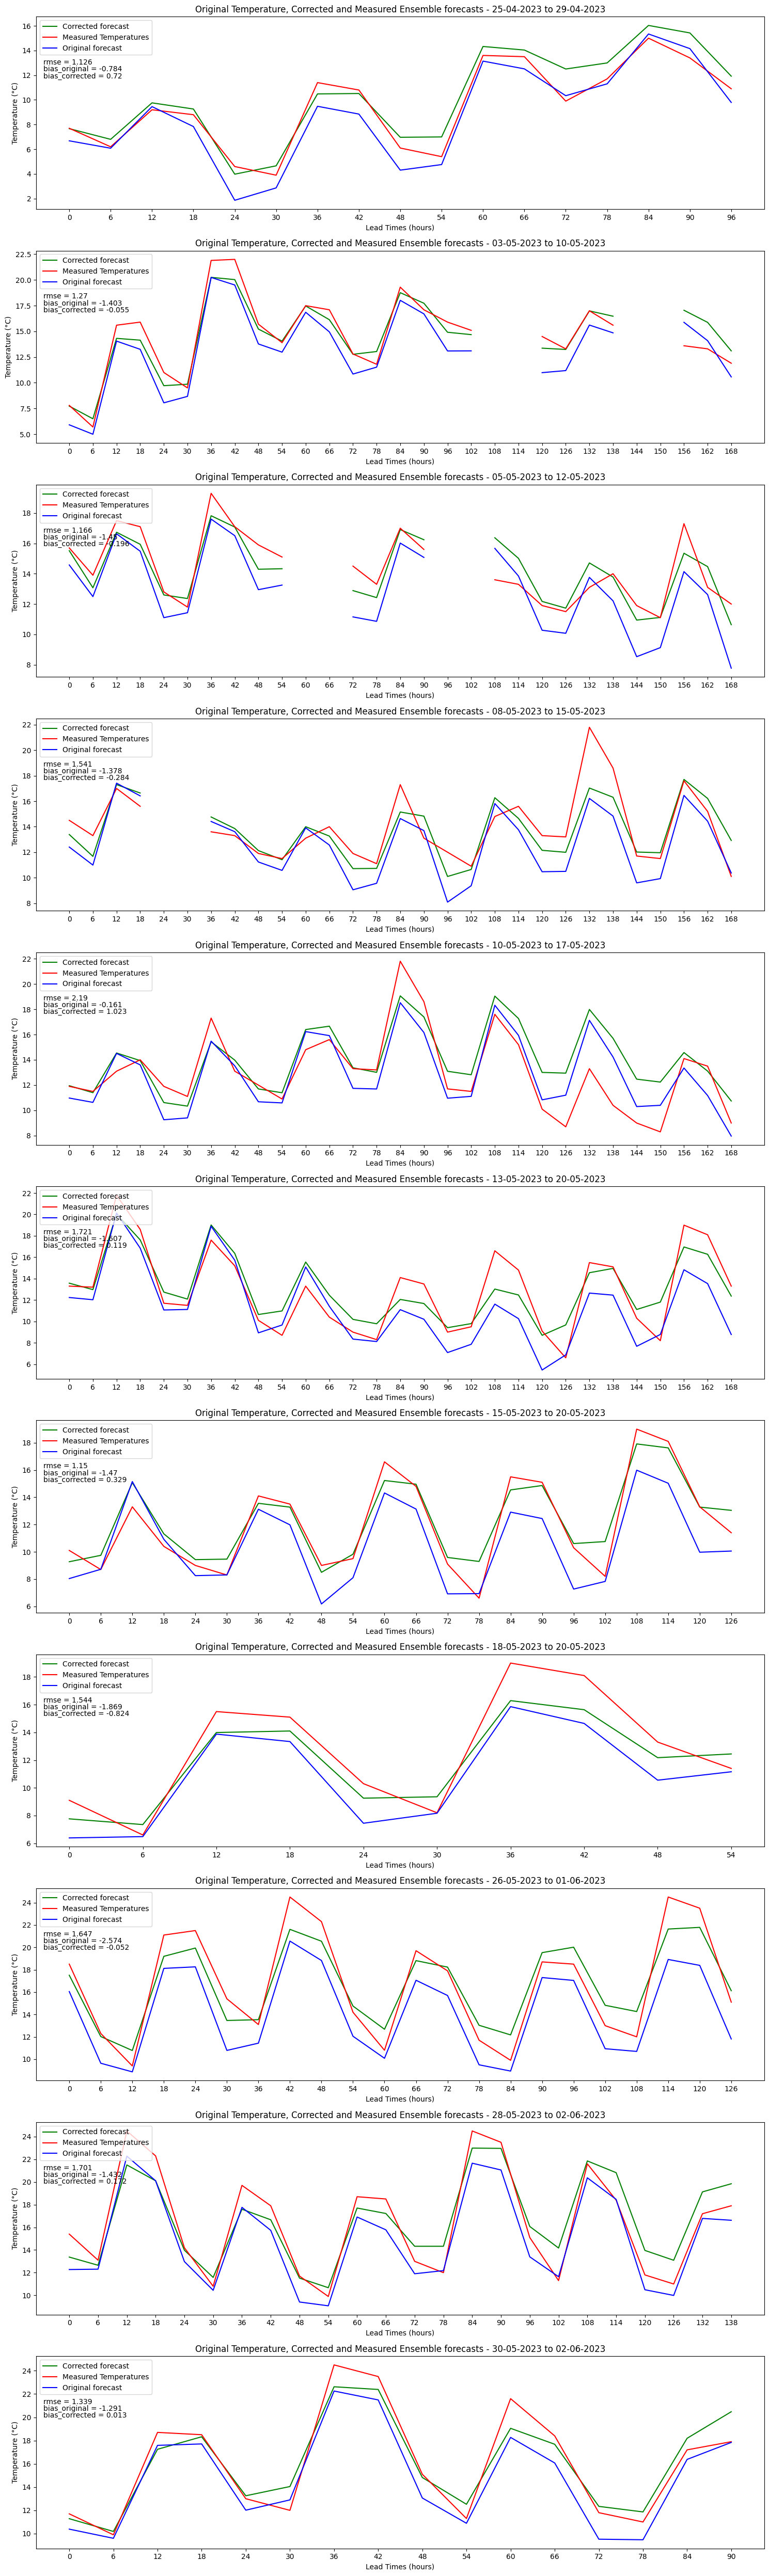

In [48]:
correct_display(val_set, best)

# Final run on test set
We selected model ... because it performed the best.

Lasso Reg
-> On individual sets:
  Average model rmse: 1.81 .
  Average baseline bias:  -1.0 degrees.
  Average corrected bias: 0.62 degrees.
  Improvement over baseline: 38.17 %.


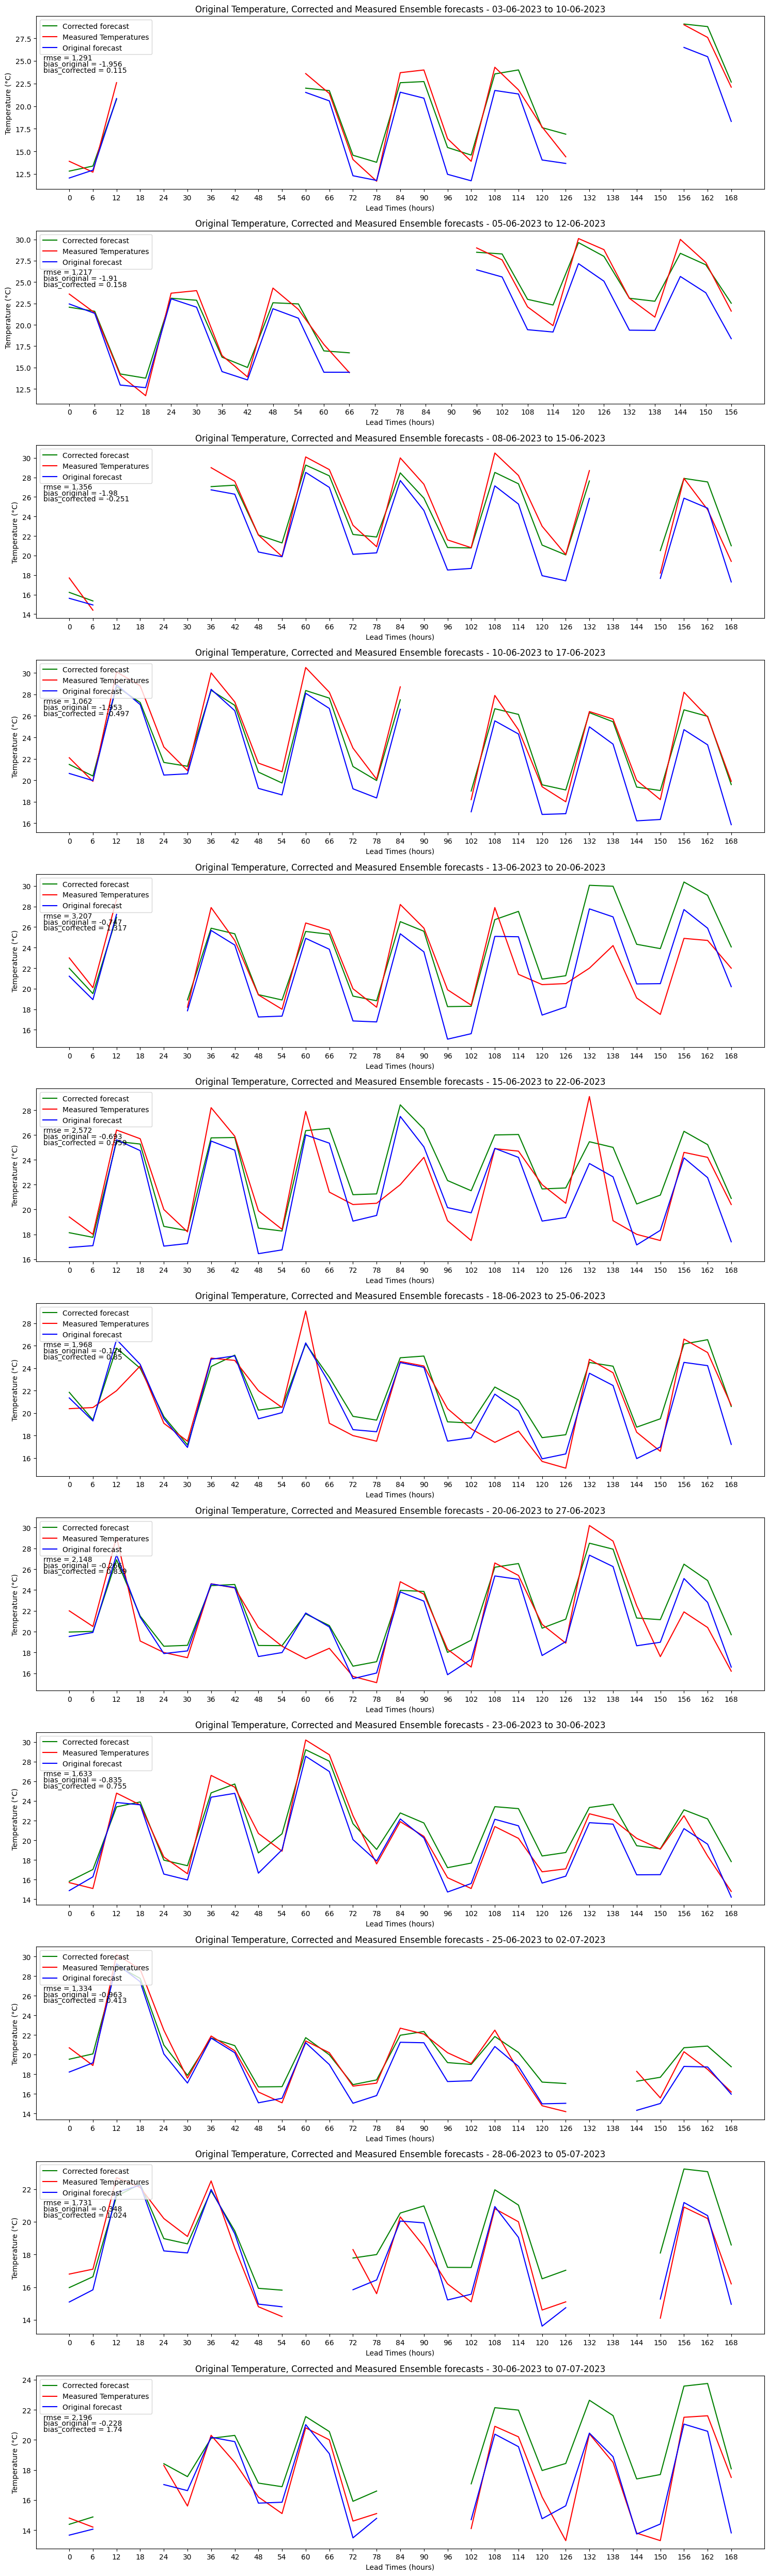

In [49]:
correct_display(test_set, best)
eval_metrics(test_set, [best])

# Correcting forecast

Code used to format dataframe to make weekly submission easier

In [50]:
import re

def keep_digits(str):
    pattern = r'\D+' 
    return re.sub(pattern, '', str)

input_csv = "Forecast_20_04_2024.csv"
to_digits = keep_digits(input_csv)
output_csv_str = "Corr-" + to_digits[4:] + to_digits[2:4] + to_digits[:2] + "_TheBlaze.csv"
to_correct = pd.read_csv(f"weekly_forecast/{input_csv}")

#save dataframe to correct for later use
prev_fc = to_correct[['time', 't2m', 'number']]
df_corrected = to_correct.copy()

#df_corrected = correct_forecast(to_correct, rf_base, partial_transform_df_rf)
#df_corrected = correct_forecast(to_correct, linear_regression, transform_df_lr_fc,)

to_correct = add_features_uhi(to_correct)
df_corrected['t2m'] = model.predict(to_correct[to_keep_lasso])
df_corrected.to_csv(f"weekly_corrected/{output_csv_str}")

KeyError: 'temp'

Displaying original and corrected forecasts

In [ ]:
def display_prev_corrected(df_fc, df_corr):
    """
        Displays forecast and corrected forecast through model
        df_fc and fc_corr should be fully features dataframes that at least have columns 'time', 't2m' and 'number'
    """
    prev_fc_mean = df_fc[['time', 't2m']].groupby('time').mean().reset_index()
    corrected_mean = df_corr[['time', 't2m']].groupby('time').mean().reset_index()
    
    hours =  np.arange(0, 6 * len(corrected_mean), 6)

    prev_fc_mean['t2m'] = prev_fc_mean['t2m'] - C_0
    corrected_mean['t2m'] = corrected_mean['t2m'] - C_0

    start = prev_fc_mean['time'].min()
    end = prev_fc_mean['time'].max()

    fig, ax = plt.subplots(figsize=(15, 8))

    # Get min and max values of previous forecast
    pvt_prev_fc = df_fc[['time', 't2m', 'number']].pivot(index='time', columns='number', values='t2m')
    y_fc_min = pvt_prev_fc.min(axis=1).values - C_0
    y_fc_max = pvt_prev_fc.max(axis=1).values - C_0
    ax.fill_between(hours, y_fc_min, y_fc_max, alpha=.2, linewidth=0)

    # get min and max value of corrected forecast
    pvt_corr_fc = df_corr[['time', 't2m', 'number']].pivot(index='time', columns='number', values='t2m')
    y_fc_min = pvt_corr_fc.min(axis=1).values - C_0
    y_fc_max = pvt_corr_fc.max(axis=1).values - C_0
    ax.fill_between(hours, y_fc_min, y_fc_max, alpha=.2, linewidth=0)

    plt.figure(figsize=(15, 8))
    ax.plot(hours, prev_fc_mean['t2m'], label='Original forecast')
    ax.plot(hours, corrected_mean['t2m'], label='Corrected forecast')
    ax.legend(loc='upper left')
    ax.set_xlabel(f"""From {start} to {end}""")
    ax.set_ylabel('Temperature')
    ax.set_title(f'Original and corrected forecast')
    ax.set_xticks(hours, [f"{h:02d}h" for h in hours], rotation=45)
    plt.show()

display_prev_corrected(prev_fc, df_corrected)